# UQ Analysis of RFQ Dataset (09-24-2020)

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3);
                                         font-size: 15px">
        <strong>Requirements:</strong>
        <ul>
            <li>pyOPALTools (https://gitlab.psi.ch/OPAL/pyOPALTools/-/tags/pyOPALTools-25-09-2020)</li>
            <li>UQTk (https://github.com/sandialabs/UQTk)</li>
        </ul>
    </div>
</html>
    

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Define Global Variables</strong>
    </div>
</html>

In [288]:
# renamed file: 'Dataset_RFQ-model_01_(09-24-2020).txt' --> 'dataset_0.json'
fname = 'dataset_0.json'

# polynomial chaos expansion order
order = 7

In [289]:
from db import mldb

database = mldb.mldb()

database.buildFromSampler(fname, '.', '')

OPAL ML Database Generator 
Write ML-Database sampler.pk


In [290]:
database.printOverview ()

xDim        = 6 -> ['DVAR1', 'DVAR2', 'DVAR3', 'DVAR4', 'DVAR5', 'DVAR6']
yDim        = 4 -> ['OBJ1', 'OBJ2', 'OBJ3', 'OBJ4']
generations = 1
Data points  = 14737
Show first dataset from generation 0: y = f(x)
[1.000e+02 6.520e-03 1.887e-02 1.676e-02] = f([  1.89793  23.05203  -3.11483   3.10531 460.92529 177.61368])


<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Save Input and Output</strong>
    </div>
</html>

In [291]:
"""Note: The ordering of the intput and output data are ordered according to 'xnames' and 'ynames' which does not
necessarily mean an increasing ordering, i.e., DVAR1, DVAR2, ... or OBJ1, OBJ", ..., respectively.
"""
import numpy as np
xnames = database.getXNames()
ynames = database.getYNames()
xdim = database.getXDim()
ydim = database.getYDim()
nsamples = database.getSampleSize()

In [292]:
xvals = np.zeros((nsamples, xdim))
yvals = np.zeros((nsamples, ydim))
for i in range(nsamples):
    xvals[i] = database.getDVarVec(0, i)
    yvals[i] = database.getObjVec(0, i)

# save data, might be used for Neural Network training
np.save('rfq_input.npy', xvals)
np.save('rfq_output.npy',yvals)

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Obtain Domain of Interest from Data</strong>
    </div>
</html>

In [293]:
import numpy as np
pdom = np.empty((2, len(xnames)))

bounds = database.getBounds()

for i in range(len(xnames)):
    pdom[0, i] = bounds[xnames[i]][0]
    pdom[1, i] = bounds[xnames[i]][1]

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Split into Training and Validation Data</strong>
    </div>
</html>

In [294]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(xvals, yvals, test_size=0.3, random_state=42)
xtrain=np.asarray(xtrain)
xtest=np.asarray(xtest)
ytrain=np.asarray(ytrain)
ytest=np.asarray(ytest)

print('Training size:   ', np.shape(xtrain)[0])
print('Validation size: ', np.shape(ytest)[0])



Training size:    10315
Validation size:  4422


<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Analysis Functions</strong>
    </div>
</html>

###  Error Measures and Sensitivity Computation

In [295]:
# error measures
def eval_l2_error(ytrue, ypred):
    return np.linalg.norm(ytrue - ypred, ord=2) / np.linalg.norm(ytrue, ord=2)

def eval_l1_error(ytrue, ypred):
    return np.linalg.norm(ytrue - ypred, ord=1) / np.linalg.norm(ytrue, ord=1)

def compute_sensitivity(xtrain, ytrain, order, pdom):
    import numpy as np
    allsens_m = np.zeros((len(ytrain[0]), len(xtrain[0])))
    allsens_t = np.zeros((len(ytrain[0]), len(xtrain[0])))
    
    # load the UQ interface
    from surrogate.uqtk_model import UQTk as UQ
    #from surrogate.chaospy_model import UQChaospy as UQ
    
    
    for i in range(len(ytrain[0])):
        # delete
        uq = None

        # setup the UQ analysis ( lsq : least squares method )
        uq = UQ(pdom=pdom, order=order, method='lsq')
    
        # train the surrogate model
        uq.fit(xtrain, ytrain[:, i])
        
        allsens_m[i, :] = uq.main_sensitivity()
        allsens_t[i, :] = uq.total_sensitivity()
    
    return allsens_m, allsens_t

###  Sensitivity Plotting Tools

In [296]:
def plot_sens(sensdata,pars,cases,vis="bar",
              par_labels=[], case_labels=[],colors=[],ncol=4,grid_show=True,xlbl='',
              legend_show=2,xdatatick=None,figname='sens.eps',showplot=False, **kwargs):

    """Plots sensitivity for multiple observables"""
    import matplotlib.pyplot as plt
    ncases=sensdata.shape[0]
    npar=sensdata.shape[1]
    
    sens_type = kwargs.pop('sens_type', '')

    wd=0.6
    ylbl= sens_type + ' Sensitivity'


    assert set(pars) <= set(range(npar))
    assert set(cases) <= set(range(ncases))

    npar_=len(pars)
    ncases_=len(cases)

    case_labels_=[]
    for i in range(ncases_):
        case_labels_.append(case_labels[cases[i]])

    if xdatatick==None:
        xflag=False
        xdatatick=np.array(list(range(1,ncases_+1)))
        sc=1.
    else:
        xflag=True
        sc=(xdatatick[-1]-xdatatick[0])/ncases_

    if (vis=="graph"):
        for i in range(npar_):
            plt.plot(xdatatick_,sensdata[cases,i], '-o',color=colors[pars[i]], label=par_labels[pars[i]])
    elif (vis=="bar"):
        curr=np.zeros((ncases_))
        #print pars,colors
        for i in range(npar_):
            plt.bar(xdatatick,sensdata[cases,i], width=wd*sc,color=colors[pars[i]], bottom=curr,
                    label=par_labels[pars[i]], capsize=5, ecolor='black')
            curr=sensdata[cases,i]+curr
        if not xflag:
            plt.xticks(np.array(list(range(1,ncases_+1))),case_labels_)
        plt.xlim(xdatatick[0]-wd*sc/2.,xdatatick[-1]+wd*sc/2.)

    plt.ylabel(ylbl)
    plt.xlabel(xlbl)

    maxsens=max(max(curr),1.0)
    plt.ylim([0,maxsens])
    if legend_show==1:
        plt.legend()
    elif (legend_show==2):
        plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.1), ncol=ncol)
    elif legend_show == 3:
        bb_shift = kwargs.pop('bb_shift', 0.0)
        plt.legend(loc = 'upper left', bbox_to_anchor=(-0.75+bb_shift, 1.25), ncol=ncol)
        #legend(bbox_to_anchor=(0.0, -0.05),fancybox=True, shadow=True,ncol=5,labelspacing=-0.1)

    #if not xflag:
    #    zed = [tick.label.set_fontsize(xticklabel_size) for tick in plt.gca().xaxis.get_major_ticks()]

    plt.grid(grid_show, linestyle='dashed', axis='y')
    #plt.tight_layout()
    return plt

def plot_sensitivity(sensdata, dnames, outnames, **kwargs):
    import matplotlib.pyplot as plt
    ## Get basic dimensions
    nout=len(outnames)
    ndim=np.shape(sensdata)[1]
    print("Dimensionality : ", ndim)
    print("Num of outputs : ", nout)

    pars=list(range(ndim))
    cases=list(range(nout))

    # 11. March 2019
    # https://stackoverflow.com/questions/43938425/matplotlib-change-colormap-tab20-to-have-three-colors
    colors = plt.cm.tab20( (4./3*np.arange(20*3/4)).astype(int) )

    return plot_sens(sensdata, pars, cases, vis='bar', colors=colors,
                     par_labels=dnames,case_labels=outnames,ncol=int(0.5*ndim),
                     grid_show=True, xlbl='', **kwargs)

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Train UQ Model and Check the Error</strong>
    </div>
</html>

In [297]:
# load the UQ interface
from surrogate.uqtk_model import UQTk as UQ
from sklearn.metrics import mean_squared_error, mean_absolute_error
predictions =[]
predictions_t=[]
surrogates=[]
# loop over all quantities of interest
for i in range(len(ytrain[0])):
    # delete
    uq = None

    # setup the UQ analysis ( lsq : least squares method )
    uq = UQ(pdom=pdom, order=order, method='lsq')
    
    # train the surrogate model
    uq.fit(xtrain, ytrain[:, i])
    surrogates.append(uq)
    # predict
    ypred_train = uq.predict(xtrain)
    
    ypred_test = uq.predict(xtest)
    predictions.append(ypred_test)
    predictions_t.append(uq.predict(xtrain))
    
    print("Quantity of interest: ", ynames[i])
    print('L2 error norm in training points:   ', eval_l2_error(ytrue=ytrain[:, i], ypred=ypred_train))
    print('L2 error norm in validation points: ', eval_l2_error(ytrue=ytest[:, i], ypred=ypred_test))
    print('L1 error norm in training points:   ', eval_l1_error(ytrue=ytrain[:, i], ypred=ypred_train))
    print('L1 error norm in validation points: ', eval_l1_error(ytrue=ytest[:, i], ypred=ypred_test))
    print('MSE in training points:             ', mean_squared_error(ytrain[:, i], ypred_train))
    print('MAE in training points:             ', mean_absolute_error(ytrain[:, i], ypred_train))
    print('MSE in validation points:           ', mean_squared_error(ytest[:, i], ypred_test))
    print('MAE in validation points:           ', mean_absolute_error(ytest[:, i], ypred_test))
    print('normalized MAE:                     ', mean_absolute_error(ytest[:, i], ypred_test)/np.average(ytest[:,i]) )
    print ("------------------------------------------------------")
    

Quantity of interest:  OBJ1
L2 error norm in training points:    0.0016878996781395498
L2 error norm in validation points:  0.0020841206333827617
L1 error norm in training points:    0.0013175911246939257
L1 error norm in validation points:  0.0015814229992093963
MSE in training points:              0.02768654908045312
MAE in training points:              0.12970612666749515
MSE in validation points:            0.04222777827198411
MAE in validation points:            0.15571577405533454
normalized MAE:                      0.0015814229992093963
------------------------------------------------------
Quantity of interest:  OBJ2
L2 error norm in training points:    0.006435304091759885
L2 error norm in validation points:  0.00959541325491178
L1 error norm in training points:    0.005152204056110666
L1 error norm in validation points:  0.0067137442771235106
MSE in training points:              7.953243170449922e-09
MAE in training points:              5.866580749231239e-05
MSE in validatio

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Generate Database</strong>
    </div>
</html>

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Plot Main and Total Sensitivities</strong>
    </div>
</html>

In [173]:
"""
allsens_m: Main sensitivity, i.e., the effect of only one parameter
allsens_t: Total sensitivity, i.e., the effect of one parameter including all correlations with other parameters
"""
allsens_m, allsens_t = compute_sensitivity(xtrain=xtrain, ytrain=ytrain, pdom=pdom, order=order)
print(allsens_m)

[[0.09087881 0.60080487]
 [0.04883927 0.52093381]
 [0.01942389 0.62779481]
 [0.02423493 0.60139344]]


No handles with labels found to put in legend.


Dimensionality :  2
Num of outputs :  4


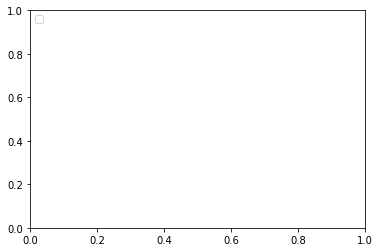

In [148]:
import matplotlib.pyplot as plt
plt.legend(loc='upper left');
plt.figure(figsize=(12, 9), dpi=150)
plt = plot_sensitivity(allsens_m, dnames=xnames, outnames=ynames, sens_type='Main')

plt.savefig('main_sensitivty_order_' + str(order) + '.png', bbox_inches='tight')
plt.close()

In [149]:
plt.figure(figsize=(12, 9), dpi=150)
plt = plot_sensitivity(allsens_t, dnames=xnames, outnames=ynames, sens_type='Total')

plt.savefig('total_sensitivty_order_' + str(order) + '.png', bbox_inches='tight')
plt.close()

Dimensionality :  2
Num of outputs :  4


10000
10000
3000
3000


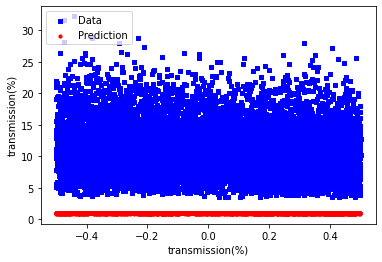

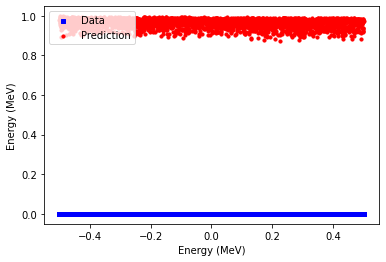

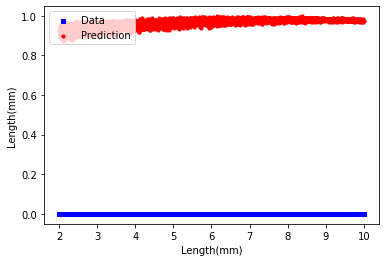

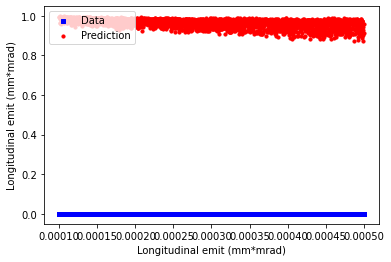

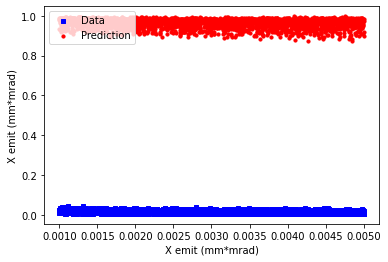

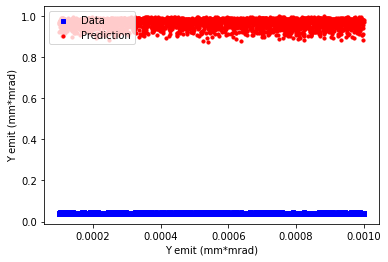

IndexError: index 6 is out of bounds for axis 1 with size 6

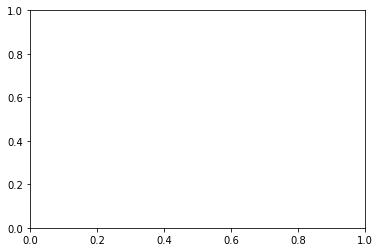

In [13]:
import numpy as np
import matplotlib.pyplot as plt

print(len(xvals))
print(len(yvals))
print(len(ypred_test))
print(len(xtest))

obj=0


while obj<12:
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.scatter(xvals[:,obj], yvals[:,obj],
             
            label='Data',
           s=10, c='b', marker="s",
            )
    ax1.scatter(xtest[:,obj], ypred_test,
             s=10, c='r', marker="o",
             label='Prediction')

    #ax1.set_ylim(0, 1.)
    plt.legend(loc='upper left');
    if obj==0:
        ax1.set_xlabel('transmission(%)')
        ax1.set_ylabel('transmission(%)')
    
    if obj==1:
        ax1.set_xlabel('Energy (MeV)')
        ax1.set_ylabel('Energy (MeV)')
        
        
    if obj==2:
        ax1.set_xlabel('Length(mm)')
        ax1.set_ylabel('Length(mm)')
        
    
    if obj==3:
        ax1.set_xlabel('Longitudinal emit (mm*mrad)')
        ax1.set_ylabel('Longitudinal emit (mm*mrad)')
        
        
    
    if obj==4:
        ax1.set_xlabel('X emit (mm*mrad)')
        ax1.set_ylabel('X emit (mm*mrad)')
        
    if obj==5:
        ax1.set_xlabel('Y emit (mm*mrad)')
        ax1.set_ylabel('Y emit (mm*mrad)')
        
#plt.plot(xvals[:,1], yvals[:,1], label='')
    plt.show()
    obj = obj +1


normalized MAE:  0.15814229992093962 %
normalized MAE (training set):  0.13175911246939256 %


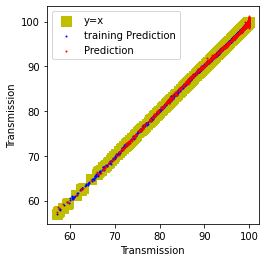

normalized MAE:  0.671374427712351 %
normalized MAE (training set):  0.5152204056110666 %


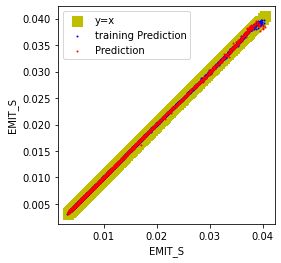

normalized MAE:  0.8182473796463503 %
normalized MAE (training set):  0.6595881313540356 %


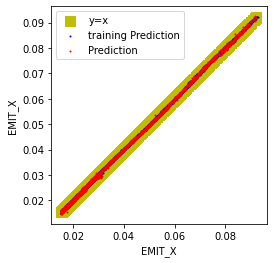

normalized MAE:  0.6348314348493503 %
normalized MAE (training set):  0.4946669091133389 %


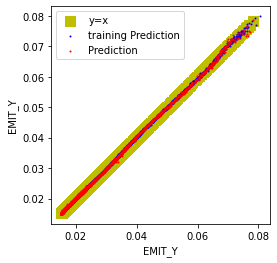

IndexError: index 4 is out of bounds for axis 1 with size 4

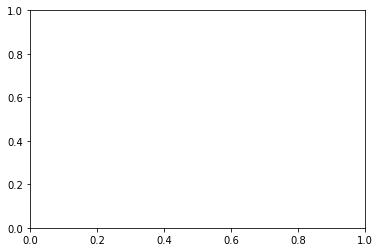

In [298]:
obj = 0
#print(xtrain)

import matplotlib.pyplot as plt
from scipy.stats import kde


while obj<20:
    
    fig = plt.figure()
    ax2 = fig.add_subplot(111)
    #ytrain.append(ytrain[1,1])
    #ytest = np.delete(ytest, 0, axis=0)
    #predictions = np.delete(predictions, 2)
#     #np.delete(ytest[:,obj], 1)
#     print(len(predictions))
#     print(len(ytest[:,obj]))
#     print(len(ytrain[:,obj]))


    
    heatplots=False
    if heatplots:
        nbins=300
        k = kde.gaussian_kde( [  ytest[:,obj], predictions[obj]  ])
        xi, yi = np.mgrid[ytest[:,obj].min():ytest[:,obj].max():nbins*1j, predictions[obj].min():predictions[obj].max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))

        ax2.pcolormesh(xi, yi, zi.reshape(xi.shape))
        #plt.show()
    
        
    
    ax2.scatter(ytest[:,obj], ytest[:,obj],
             
             label='y=x',
            s=100, c='y', marker="s",
             )
    ax2.scatter(ytrain[:,obj], predictions_t[obj],
             s=1, c='b', marker="o",
             label='training Prediction')
    
    ax2.scatter(ytest[:,obj], predictions[obj],
             s=1, c='r', marker="o",
             label='Prediction')
#     ax2.scatter(ytest[:,obj], ytrain[:,obj], 
#              s=1, c='g', marker="o",
#              label='Prediction')

    
    

    
    
    ax2.set_aspect(1)
    
    
    print('normalized MAE: ', 100* mean_absolute_error(ytest[:, obj], predictions[obj])/np.average(ytest[:,obj]) , '%' )    
    print('normalized MAE (training set): ', 100* mean_absolute_error(ytrain[:, obj], predictions_t[obj])/np.average(ytrain[:,obj]) , '%' )    
    if obj==0:
        ax2.set_xlabel('Transmission')
        ax2.set_ylabel('Transmission')
        ax2.set_aspect(1)
        
    if obj==1:
        ax2.set_xlabel('EMIT_S')
        ax2.set_ylabel('EMIT_S')
        ax2.set_aspect(1)
        
    if obj==2:
        ax2.set_xlabel('EMIT_X')
        ax2.set_ylabel('EMIT_X')
        ax2.set_aspect(1)
    
    if obj==3:
        ax2.set_xlabel('EMIT_Y')
        ax2.set_ylabel('EMIT_Y')
        ax2.set_aspect(1)
        
    
    if obj==4:
        ax2.set_xlabel('X emit (mm*mrad)')
        ax2.set_ylabel('X emit (mm*mrad)')
#         ax2.set_xlim(.01, .07)
#         ax2.set_ylim(.01, .07)
                
    if obj==5:
        ax2.set_xlabel('Y emit (mm*mrad)')
        ax2.set_ylabel('Y emit (mm*mrad)')
        ax2.set_xlim(.01, .07)
        ax2.set_ylim(.01, .07)
        ax2.set_aspect(1)
        

    #ax2.set_xlim(0.055, .1)
    #ax2.set_ylim(0, .1)
    #ax2.set_xlim(0, .1)
    plt.legend(loc='upper left');
    

#plt.plot(xvals[:,1], yvals[:,1], label='')
   
    plt.show()
    #print(" value:  ",  pow(np.average(predictions[obj]-ytest[:,obj]), 2)      /       pow(np.average(ytrain[:,obj]), 2))
    
    
    obj = obj +1


In [ ]:
#print(xtest)




i=0

print("output:  ")
#print(output)
#print(len(output))
print("   ")
print("xtest:   ")
print(xtest)
print(len(xtest[i,:]))
print(len(xtest[:,i]))



xinput = [[10.01277,
102.13058,
11.38499,
150.15528,
149.87416,
32.79421,
47.35732,
91.13554,
1.0339,
1.18602,
1.55939,
-85.4561,
-65.20657,
-56.44278],[0,0,0,0,0,0,0,0,0,0,0,0,0,0]
         ]


outputs =[]


# while i<14:
    
#      print(xtest[0,i]         )
#      #outputs.append(output[i])
#      #print(output[i])
     
#      i=i+1

p=0
while p<6:
    outputs.append(surrogates[p].predict(xinput))
    print(surrogates[p].predict(xinput))
    p=p+1    
    print(len(outputs))

print("")    
print("outputs: ")    
print("")
p=0
while p<6:
    print(outputs[p][0])
    p=p+1        
    


    
    
    
weights =[1,1,1,1,1,1,1]
# #utility = 




avg:  98.772


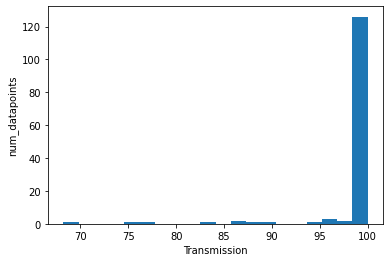

avg:  0.009998928571428572


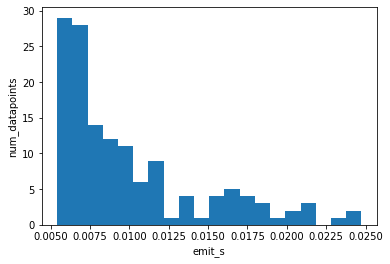

avg:  0.04264442857142857


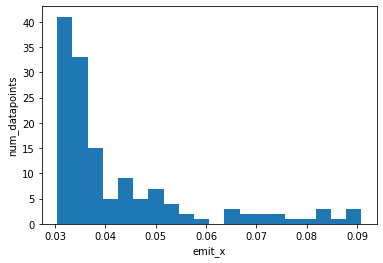

avg:  0.041741714285714285


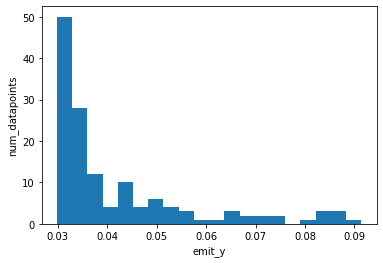

IndexError: index 4 is out of bounds for axis 1 with size 4

In [230]:
i=0
while i<6:
    plt.hist(ytrain[:,i], bins=20)
    if i==0:
        plt.xlabel('Transmission')
        plt.ylabel('num_datapoints')
        print("avg: ",np.average(ytrain[:,i]))
    
    if i==1:
        plt.xlabel('emit_s')
        plt.ylabel('num_datapoints')
        print("avg: ",np.average(ytrain[:,i]))
        
    if i==2:
        plt.xlabel('emit_x')
        plt.ylabel('num_datapoints')
        print("avg: ",np.average(ytrain[:,i]))
        
    
    if i==3:
        plt.xlabel('emit_y')
        plt.ylabel('num_datapoints')
        print("avg: ",np.average(ytrain[:,i]))
        
        
    
    if i==4:
        plt.xlabel('X emit (mm*mrad)')
        plt.ylabel('num_datapoints')
        print("avg: ",np.average(ytrain[:,i]))
    if i==5:
        plt.xlabel('X emit (mm*mrad)')
        plt.ylabel('num_datapoints')
        print("avg: ",np.average(ytrain[:,i]))
    #print(" value:  ",  pow(np.average(predictions[obj]-ytest[:,obj]), 2)      /       pow(np.average(ytest[:,obj]), 2))
    plt.show()
    i=i+1



avg:  1.9582967142857144


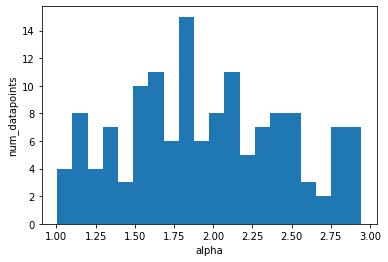

avg:  13.101069642857142


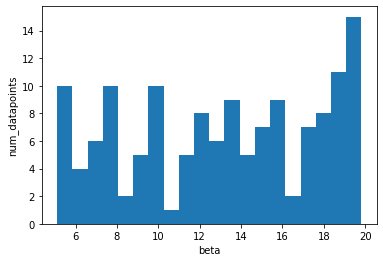

IndexError: index 2 is out of bounds for axis 1 with size 2

In [231]:
i=0
while i<6:
    plt.hist(xtrain[:,i], bins=20)
    if i==0:
        plt.xlabel('alpha')
        plt.ylabel('num_datapoints')
        print("avg: ",np.average(xtrain[:,i]))
    
    if i==1:
        plt.xlabel('beta')
        plt.ylabel('num_datapoints')
        print("avg: ",np.average(xtrain[:,i]))
        
    if i==2:
        plt.xlabel('I0')
        plt.ylabel('num_datapoints')
        print("avg: ",np.average(xtrain[:,i]))
        
    
    if i==3:
        plt.xlabel('rmst')
        plt.ylabel('num_datapoints')
        print("avg: ",np.average(xtrain[:,i]))
        
        
    
    if i==4:
        plt.xlabel('rmsx')
        plt.ylabel('num_datapoints')
        print("avg: ",np.average(xtrain[:,i]))
    if i==5:
        plt.xlabel('rmsy')
        plt.ylabel('num_datapoints')
        print("avg: ",np.average(xtrain[:,i]))
    #print(" value:  ",  pow(np.average(predictions[obj]-ytest[:,obj]), 2)      /       pow(np.average(ytest[:,obj]), 2))
    plt.show()
    i=i+1



In [ ]:
from scipy.optimize import minimize_scalar


import itertools as it
import subprocess
from scipy import optimize as opt
import numpy as npr
from time import time, ctime
from datetime import date
from datetime import datetime as dt
import wave
import random
import multiprocessing as mp
from bayes_opt import BayesianOptimization
import sys
import os
import numpy as np




def opt_fun (dvar1,dvar2,dvar3,dvar4,dvar5,dvar6,dvar7,dvar8,dvar9,dvar10,dvar11,dvar12,dvar13,dvar14):
    
    
    
    
    
    
    utility=-99999
#     utility=0
#     dvar1=x[0]
#     dvar2=x[1]
#     dvar3=x[2]
#     dvar4=x[3]
#     dvar5=x[4]
#     dvar6=x[5]
#     dvar7=x[6]
#     dvar8=x[7]
#     dvar9=x[8]
#     dvar10=x[9]
#     dvar11=x[10]
#     dvar12=x[11]
#     dvar13=x[12]
#     dvar14=x[13]
#     obj=x[14]
    
    
    
    
    
    
    
    xinput = [[dvar1,
    dvar2,
    dvar3,
    dvar4,
    dvar5,
    dvar6,
    dvar7, 
    dvar8, 
    dvar9, 
    dvar10,
    dvar11,
    dvar12,
    dvar13, 
    dvar14],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0]
         ]
    outputs=[]
    outputs.clear()
    obj=6
    p=0
    while p<obj:
        outputs.append(surrogates[p].predict(xinput))
        p=p+1    
    
    
    optimum = [100, 70, 130, 0, 0, 0]
    weights= [ 0.4/50, 0.05/.075, 0.05/140, 0.4/.006, 0.05/.0035, 0.05/.0035]
    obj=6
    
    
    i=0
    while i<obj:
        if outputs[i][0] >= 0:
            utility += -((optimum[i]-outputs[i][0])*(optimum[i]-outputs[i][0])*weights[i])
        if outputs[i][0] < 0:
            utility += -999999.0 -((optimum[i]-outputs[i][0])*(optimum[i]-outputs[i][0])*weights[i])

        print(outputs[i][0])
        i=i+1
        
        
    if outputs[0][0] > 100.0:
        utility += -999999.0*(outputs[0][0]-100)
    if outputs[2][0] > 180.0:
        utility += -999999.0*(outputs[2][0]-180)
        
        
        
          
    print(" utility: ", utility)
    print("_________________________________________________________________________________")
    return utility
    
    
    

# x0 = [10.01277,
# 102.13058,
# 11.38499,
# 150.15528,
# 149.87416,
# 32.79421,
# 47.35732,
# 91.13554,
# 1.0339,
# 1.18602,
# 1.55939,
# -85.4561,
# -65.20657,
# -56.44278,
#      6]


#print(opt_fun(x0))
#res = minimize(opt_fun, x0, method='nelder-mead',
#               options={'xatol': 1e-5, 'disp': True})
#res = minimize_scalar(opt_fun, bounds=    )

field_scale = 1 # Adjustments to field strength weight for optimization
# Params for optimizer
n_iter = 10000
init_points = 10




def main():
    numProc = mp.cpu_count() # Number of Processes to spawn
    x0 = np.asarray([000.0, 00.0, 000.0])
    dimension=14
    start = time()

    print('Optimizing using BO, PP')

    #dvar1min, dvar2min, dvar3min, dvar4min, dvar5min, dvar6min, dvar7min, dvar8min, dvar9min, dvar10min, dvar11min, dvar12min,  dvar13min, dvar14min = 30,30,30,30,30,30,30,30,30,30,30,30,30,30
    dvar1min, dvar2min, dvar3min, dvar4min, dvar5min, dvar6min, dvar7min, dvar8min, dvar9min, dvar10min, dvar11min, dvar12min,  dvar13min, dvar14min = 10.01277,102.13058,8.38499,120.15528,129.87416,32.79421,47.35732,91.13554,1.0339,1.18602,1.55939,-85.4561,-5.20657,-56.44278
    #dvar1max, dvar2max, dvar3max, dvar4max, dvar5max, dvar6max, dvar7max, dvar8max, dvar9max, dvar10max, dvar11max, dvar12max,  dvar13max, dvar14max = 40,40,40,40,40,40,40,40,40,40,40,40,40,40
    dvar1max, dvar2max, dvar3max, dvar4max, dvar5max, dvar6max, dvar7max, dvar8max, dvar9max, dvar10max, dvar11max, dvar12max,  dvar13max, dvar14max = 20.01277,112.13058,11.38499,150.15528,150.87416,35.79421,50.35732,96.13554,1.839,2.18602,2.55939,-75.4561,-3.20657,-46.44278

    print(opt_fun(dvar1min, dvar2min, dvar3min, dvar4min, dvar5min, dvar6min, dvar7min, dvar8min, dvar9min, dvar10min, dvar11min, dvar12min,  dvar13min, dvar14min))
    
#     bnds = {
#         (dvar1min, dvar1max),
#         (dvar2min, dvar2max),
#         (dvar3min, dvar3max),
        
#         (dvar4min, dvar4max),
#         (dvar5min, dvar5max),
#         (dvar6min, dvar6max),
#         (dvar7min, dvar7max),
#         (dvar8min, dvar8max),
#         (dvar9min, dvar9max),
#         (dvar10min, dvar10max),
#         (dvar11min, dvar11max),
#         (dvar12min, dvar12max),
        
#         (dvar13min, dvar13max),
#         (dvar14min, dvar14max)
        
#         }
    
    
    
    
    # 18 parameter bounds Format: 'name': (min, max), 
    bnds = {
        'dvar1': (9.5, 10.50),
        'dvar2': (15.0, 120.0),
        'dvar3': (25.0, 140.0),
        'dvar4': (1.01, 1.6),
        'dvar5': (1.07, 1.7),
        'dvar6': (20.0, 450.0),
        'dvar7': (20.0, 450.0),
        'dvar8': (-70.0, -20.0),
        'dvar9': (-75.0, -17.0),
        'dvar10': (20.0, 450.0),
        'dvar11': (20.0, 450.0),
        'dvar12': (1.2, 1.9),
        'dvar13': (-75.0, -30.0 ),
        'dvar14': (.0055, .0075)
         } 





    
    
    # Optimization process
    optimizer = BayesianOptimization(
        f=opt_fun,
        
        pbounds=bnds,
        verbose=0,
        random_state=1,
    )

    optimizer.maximize(
        init_points=init_points,
        n_iter=n_iter,
    )
    results = optimizer.max


    print('-------------------------------------------------')
    print( 'OPTIMIZATION ENDED' )
    print( "utility:", -1*results['target'])
    print ("params: ", results['params'])
    

    end = time()
    print("Elapsed time: ", end - start, " seconds")
    


    print("optimization completed:", dt.now().strftime('%y.%m.%d-%H:%M:%S')        )
  
    
    
    
main()



Optimizing using BO, PP
76537716422925.03
101455768449.3057
191428426388684.3
-99014253146.75159
249672972417.7626
-34876068589.88986
 utility:  -6.152023735691086e+25
_________________________________________________________________________________
-6.152023735691086e+25
258.3260756453624
0.1913031723013335
338.7694419499664
-0.5609441866021804
0.6495201296830517
-0.03950328410687227
 utility:  -319198689.465364
_________________________________________________________________________________
260.9995149835614
0.1751402179215743
374.8602433541851
-0.3899271832908242
0.5309732396050942
-0.174405577456454
 utility:  -357962893.1968392
_________________________________________________________________________________
268.5222807893807
0.2318295538652027
361.9740313004221
-0.2570070786291421
0.4104761363482026
0.02180585421660895
 utility:  -351599457.89250076
_________________________________________________________________________________
223.8840221324125
0.2873558745864364
413.00923565

83.39089131026145
-0.1732755119721387
99.65510069598247
0.1850698338903448
0.1823034701827484
-0.2863029700342362
 utility:  -2103286.323985956
_________________________________________________________________________________
218.1765603595251
0.2034323741562243
326.1315581936608
-0.2780030571980186
0.317294358612207
0.05454833444561845
 utility:  -265411232.04943377
_________________________________________________________________________________
-77.56773876305766
-0.05600317665175286
192.5013926778722
0.02065053621678616
0.2073392930903827
-0.3185232317848966
 utility:  -15604903.801719442
_________________________________________________________________________________
-80.54061656484288
-0.07417948958420283
204.3179937914863
-0.04598520363186701
0.1636586567892135
-0.1928966133711734
 utility:  -28421501.854284417
_________________________________________________________________________________
17.28175550596134
0.08099685183401735
252.1073222187242
-0.7559275511177538
0.259565851

74.91221885303167
0.2047458586676106
302.3161734691152
-0.2405142892902913
0.474360824805767
-0.0854393868974415
 utility:  -124419318.55301505
_________________________________________________________________________________
71.01351550290558
-0.1696711952313368
87.16404726199488
0.1196006973788523
0.1517929132974719
-0.2370103728814188
 utility:  -2103288.9841602473
_________________________________________________________________________________
294.542887511414
0.1334913536511103
285.0227354009693
-0.2455437908666048
0.2671835423617959
-0.01509743596230625
 utility:  -301668890.9669904
_________________________________________________________________________________
67.74083798579666
-0.1716055184133618
107.8801813924546
0.1511837879157956
0.1335679670057071
-0.2367592278192421
 utility:  -2103290.782204233
_________________________________________________________________________________
-99.34687092355841
-0.0659745744831204
201.6583128586188
-0.06172562070259505
0.161895189932043

99.23958192565112
0.04228760729745129
337.2576605996236
0.3896879783454512
0.1516471124051522
-0.1320145406876935
 utility:  -158360790.1102162
_________________________________________________________________________________
8.895600844486417
0.1076786562403439
261.4744636450054
0.2607902901770337
0.1023925084923127
-0.2568962708322412
 utility:  -82577714.9951032
_________________________________________________________________________________
-8.391321310419364
0.06474783608459347
336.1423264480296
0.2608546243574124
0.2139923172504944
-0.180207197481367
 utility:  -158245542.75257272
_________________________________________________________________________________
91.46983645736353
0.08948294985708383
323.8045410800279
0.3815075924646879
0.3557646748502626
-0.2664137221847039
 utility:  -144907680.1174874
_________________________________________________________________________________
43.19187224121738
-0.3086416742748469
95.05478251132892
0.2981861397570199
0.4508146119441284
-0.

144.8469868740859
0.1034368371916414
234.2161189062617
0.1769214677034103
0.1718720420085439
-0.1709635625564436
 utility:  -100166284.6321803
_________________________________________________________________________________
77.19486461011411
0.09314881291184274
248.9071048750722
0.4517663502583532
0.3425215089818091
-0.02115949842444186
 utility:  -70010316.445329
_________________________________________________________________________________
59.93487975397574
-0.1754219861222402
92.09219860133777
0.2204505770783123
0.0940571960207848
-0.2302271202173273
 utility:  -2103297.5383131774
_________________________________________________________________________________
245.9617612530728
-0.1776964594664825
91.0526213550894
0.1651972432084273
0.1022228749913978
-0.05969050392479285
 utility:  -148065068.5639873
_________________________________________________________________________________
251.6069283200853
0.04814991284006481
145.4928450230958
0.2397804174880288
0.04363857909414115
-0

309.3479660925507
0.3107450553426197
417.159413557688
-0.3916983613002911
0.9010281624811356
-0.2643028024775034
 utility:  -448610570.7581167
_________________________________________________________________________________
301.5891460705476
0.08071969539324908
159.0216237084783
-0.1443054767085278
0.2324463998878844
-0.0128699590855315
 utility:  -203692528.1873632
_________________________________________________________________________________
104.7186940618739
-0.3461758445135202
87.80196338903491
0.1584850613919046
0.4739627088497658
-0.5989057499628597
 utility:  -6821996.22133629
_________________________________________________________________________________
0.2194428400189636
-0.04567017281581767
167.1317737771499
0.2760828757068247
0.2768984789637025
-0.2971526801259478
 utility:  -2103355.5105007426
_________________________________________________________________________________
86.81724019269156
0.0911602190481278
328.1265122813166
-0.1732437560091545
0.3578930903949452


289.4693853067739
0.2793466310592078
404.5079422176718
-0.3813150714918581
0.7403498552941643
-0.1645639048630988
 utility:  -416080483.20554376
_________________________________________________________________________________
-74.33041457981105
-0.05832306120058341
183.7471845420098
-0.027677222218536
0.1608337317577099
-0.2729839761373266
 utility:  -7850693.552872027
_________________________________________________________________________________
213.0493751861065
-0.1690102730634977
107.5594485623942
0.3756201578482571
0.2678565550605727
-0.2012153670139321
 utility:  -115152655.02725956
_________________________________________________________________________________
180.478594016699
0.1596512309934539
311.8578770983906
-0.3297914415247642
0.3765099243752001
-0.006825578965647866
 utility:  -214439580.4640907
_________________________________________________________________________________
-3.243178726452591
-0.06320440515316679
234.0823921230427
0.02100437785934829
0.27325495899

-26.34768251349058
-0.06758228069268346
193.2268662366336
0.03507019443227534
0.2750108372695076
-0.2418118741195421
 utility:  -16330253.122546043
_________________________________________________________________________________
58.83175891263178
-0.1746013122341498
105.8479376311352
0.2410120884754565
0.1043003598420816
-0.2696740799672264
 utility:  -2103298.816813849
_________________________________________________________________________________
-53.11547608155106
-0.06692929910865833
192.5955614994984
0.03922327350776052
0.2740411040299043
-0.2869195345572332
 utility:  -15699009.12591602
_________________________________________________________________________________
268.390652262498
0.1593363437302237
298.1234777175149
-0.1401569284284333
0.479309700491464
-0.2425081793654262
 utility:  -288617334.64791185
_________________________________________________________________________________
12.75858630692101
-0.0689404814317906
208.0308836681283
0.02939788617368312
0.283999999102

-51.5377999932386
-0.07038286461535032
186.4439743603631
0.03373832089011659
0.2243448730166073
-0.2105009226368709
 utility:  -9547423.430796202
_________________________________________________________________________________
183.0586645919273
-0.1839501763039078
106.7022021386481
0.4944830786504048
0.210326283664734
-0.2489924670936628
 utility:  -85161935.59349291
_________________________________________________________________________________
271.4516050655808
0.1317571301152771
280.8264573137087
-0.2804668216963204
0.4602355674363429
-0.05958483683605049
 utility:  -274381293.0926477
_________________________________________________________________________________
156.785327592793
-0.05086201530790849
219.22574842586
-0.4317472969867497
0.2827478602654396
-0.4610679309891994
 utility:  -99114292.66902348
_________________________________________________________________________________
373.6599771132302
0.1671094769755187
330.7620811617386
-0.3568450808560776
0.3767320863201025
-

-79.88924533935153
-0.06390707134433182
195.2411530297646
0.008862697277802548
0.2429929434709456
-0.3155106220873565
 utility:  -18344669.094775386
_________________________________________________________________________________
27.42052460840188
-0.0697106091923439
211.181192205286
0.02788306754003879
0.2782991006263081
-0.1108986971471783
 utility:  -33284477.03023329
_________________________________________________________________________________
78.65292015842215
0.1246875258931321
251.3270915536565
-0.1794092735714364
0.2849546594130788
-0.1050183928750576
 utility:  -73430284.6323022
_________________________________________________________________________________
-74.1080669076639
-0.05567720222591194
215.9918039605873
-0.08899674511180418
0.2057853261969174
-0.2444828846970753
 utility:  -40095281.970810115
_________________________________________________________________________________
-43.12597052909978
-0.04859268076456205
169.3346546645404
0.3268618418424738
0.235363419

147.0833494217008
0.08731386406069112
328.5498161187075
0.3931099016071619
0.3058813033812113
-0.0444836559491799
 utility:  -196736269.91097626
_________________________________________________________________________________
83.35305035904534
-0.1760141258191711
124.3738411207536
0.1854199645972285
0.1417300509059594
-0.2485636748090681
 utility:  -2103285.805205726
_________________________________________________________________________________
132.0575927661588
-0.176881568794046
107.6384375527095
0.1012742306939042
0.145881720862768
-0.1895658803201015
 utility:  -34160850.8062828
_________________________________________________________________________________
-64.96638058379503
-0.07308281722300403
179.1419979475681
0.0442762216373724
0.1871233503356697
-0.1785978063291097
 utility:  -3103489.151603858
_________________________________________________________________________________
37.1399056413411
-0.3186616996414852
62.94125580441255
0.2726137026069207
0.4236497844783879
-0.

115.1745136683081
-0.1733480250317646
125.7709744994616
0.1823655078736354
0.1848816367005083
-0.2297196360218662
 utility:  -17277783.667478804
_________________________________________________________________________________
-10.36613828960036
-0.06091634576599858
214.3314393277475
-0.07582433309316351
0.2179910977130705
-0.0977847663384233
 utility:  -38434773.53512122
_________________________________________________________________________________
-86.16897935886371
-0.06767767336231037
206.1286573114863
0.03449783250035034
0.2491025883188212
-0.2594815637490347
 utility:  -29232181.437755812
_________________________________________________________________________________
83.61376839711248
-0.3120711638318522
89.70845434205934
0.2067737926027146
0.4732763102348335
-0.6373803086728318
 utility:  -2103307.4399392935
_________________________________________________________________________________
43.27557961097618
0.0142331474029872
268.7181175718458
0.3826318409978454
0.3865147349

258.8460531668288
0.1155359141971337
299.54782491917
-0.1214639807438365
0.7522141486250041
-0.375880770013042
 utility:  -280497075.79265136
_________________________________________________________________________________
282.5863290018137
0.06334580231951402
252.0147023408221
-0.1274101851225979
0.2260055195221026
-0.02553605878088638
 utility:  -256704308.33903927
_________________________________________________________________________________
92.751452218864
-0.1459379447591424
167.1687117275579
-0.08020344506624405
0.4663294894907312
-0.4653776119711885
 utility:  -3103283.8448732058
_________________________________________________________________________________
198.7605152359377
0.1715718274586614
297.2942449390787
-0.386198883475673
0.4466051767411029
-0.03811291963807957
 utility:  -218157892.63120973
_________________________________________________________________________________
-11.28506056401269
-0.0668189457627261
208.7448614401038
-0.03768184685058422
0.2067470523733

290.0620249102789
0.1563928605115047
318.8542022782542
-0.3837815333343964
0.3626548058039226
-0.1381095256169905
 utility:  -331019461.05556554
_________________________________________________________________________________
235.2027521730748
0.2062252653333793
350.322853550718
-0.09985472223934201
0.3574306383108824
-0.001237934466977383
 utility:  -307628710.71012217
_________________________________________________________________________________
281.1654116456839
0.1249179409329296
258.5825563088446
-0.1376385455200568
0.3095773499752676
-0.107122757101505
 utility:  -261851231.49269223
_________________________________________________________________________________
263.5123465499449
-0.369017722803196
12.48422017227142
-0.178895824337919
0.2689707104042536
-0.6250147523152314
 utility:  -166615707.80683482
_________________________________________________________________________________
106.1204970683061
-0.1872696097356738
154.0640510332755
0.2182754141846504
0.197955013623814

4.221665211657573
-0.04082428348320463
171.8835000787471
0.2955196341423223
0.3019194426771137
-0.323710515659361
 utility:  -2103350.1137908115
_________________________________________________________________________________
359.0273419383388
0.01076866366895815
207.3417945408202
-0.2965495825779542
0.3712242881040883
-0.05472305701767156
 utility:  -288472659.54357797
_________________________________________________________________________________
-101.9569189552422
-0.06699571169808419
175.8767873109173
-0.06984975534572797
0.1230910792318998
-0.2508080300273731
 utility:  -4103596.4073930136
_________________________________________________________________________________
-18.96551002913412
0.0803352657452853
216.0678427241039
-0.2099603458589073
0.2316477358398059
-0.09837195869303529
 utility:  -39171181.54092483
_________________________________________________________________________________
-44.3575123295109
-0.06991651971533702
185.7130892267552
-0.004546145721642456
0.1869

-56.76281898327455
-0.07365080875878699
190.4439749495569
0.05799481510945838
0.221714795558462
-0.1766796631285605
 utility:  -13547433.323818376
_________________________________________________________________________________
271.6771749580196
0.07361904636569805
262.6680034266774
-0.4531876046761046
0.5960354517302271
-0.3217836168181788
 utility:  -256448443.15536794
_________________________________________________________________________________
-9.065395071627172
0.09219157971629577
241.0507046880058
-0.2920022027101733
0.1790781389479498
0.02143834371179176
 utility:  -63154004.420594424
_________________________________________________________________________________
116.619214347136
-0.308392527741961
86.58329832665405
0.2327979525615405
0.6015351095003331
-0.7309988911210352
 utility:  -18722509.540003836
_________________________________________________________________________________
121.5243963376361
-0.1743446736941105
128.7048914883335
0.1761694832489271
0.195120709308

273.6131547487478
0.2225830720062454
388.1755792641997
-0.2514337167394428
0.8089309710444852
-0.1830147022499813
 utility:  -383891874.1281524
_________________________________________________________________________________
17.06657534907806
-0.07701785438638958
198.6380784497626
0.04947216859936567
0.2288197218499907
-0.04976124781970771
 utility:  -20741388.3233466
_________________________________________________________________________________
76.9534188372321
-0.03734682961525723
223.3303746407105
-0.1083915315971237
0.3114762461627925
-0.1494248026361402
 utility:  -46433607.311889604
_________________________________________________________________________________
-3.98822758209559
-0.163366484273448
135.500567892065
-0.00983338644383884
0.4168493709618106
-0.5146302092702546
 utility:  -4103369.723485155
_________________________________________________________________________________
216.3728443538006
0.1610467855294982
340.9768418759882
-0.3764556622321441
0.271964852355656

34.41124081311818
-0.03719325659296467
215.4043448525735
0.3213854627988088
0.2901291620695461
-0.3164046190746011
 utility:  -37507623.12581234
_________________________________________________________________________________
124.2587633808792
-0.3071311412315091
79.90685700146707
0.182541679889879
0.4811188576247814
-0.6009087191639693
 utility:  -26362047.807998374
_________________________________________________________________________________
103.6951909508212
-0.2988616557210447
74.29450089264469
0.1352708470182846
0.5175177437796137
-0.6324362840030435
 utility:  -5798490.852967376
_________________________________________________________________________________
182.2891829017096
0.265493204188089
379.9220276298011
-0.2753412538727769
0.5972511968220235
-0.1128965827995687
 utility:  -284314254.0662867
_________________________________________________________________________________
259.272638807967
0.1663005287043624
298.0759863858351
-0.2611327917533268
0.4963621691937605
-0.

89.83304767667143
-0.3039536139433692
75.21289650389826
0.1220230351832164
0.5053742194061406
-0.6257062085831784
 utility:  -2103304.230439677
_________________________________________________________________________________
20.28468421886119
-0.07205454179819054
196.6006975812426
-0.003885133357672696
0.1907189654775066
-0.004479275621857626
 utility:  -19704003.317095347
_________________________________________________________________________________
229.6695281539115
0.2151406123515627
399.7702697116994
-0.3900912660357967
0.8582711921567932
-0.2578846434021625
 utility:  -351542874.1665547
_________________________________________________________________________________
246.4538479221538
0.2224956958532834
315.8614419493667
-0.3812477720286064
0.3433106862850648
-0.003717962166893601
 utility:  -284418445.79071903
_________________________________________________________________________________
145.513023261893
-0.171192586354458
113.9578434121187
0.1631343871129997
0.17626980723

257.8301737258689
0.2494297911021373
360.5119229383964
-0.2553913707184418
0.5558011769680933
-0.119704830230283
 utility:  -340445225.9762516
_________________________________________________________________________________
254.322316788885
0.248718733731462
384.823015274056
-0.5056724514854962
0.5315412403920157
0.0006567333879309023
 utility:  -360248449.20898765
_________________________________________________________________________________
128.3051701532789
-0.1736236501352755
88.1901402324626
0.2740137003616914
0.09490959237913205
-0.132204593175571
 utility:  -30408434.157453164
_________________________________________________________________________________
9.09774739064627
-0.05289320250481247
204.2183360896153
-0.06848785774921885
0.2740356481994032
-0.2253875837989647
 utility:  -27321649.660745263
_________________________________________________________________________________
276.1999259673152
0.1436393352919007
318.3326638141564
-0.3747165907092806
0.2375874470479827


55.9209961806926
-0.3134210678252768
54.6569375546764
0.351222200343637
0.387444607239105
-0.5938103552601737
 utility:  -2103325.961380323
_________________________________________________________________________________
101.3547848779785
-0.1262176535410645
136.3544021983551
-0.2072932995048984
0.4244493504304178
-0.4005660737047929
 utility:  -4458065.740463717
_________________________________________________________________________________
168.13471286866
-0.1786511250514234
112.7190759854958
0.2335641500450439
0.214359968481074
-0.1500485181700695
 utility:  -70237966.9562448
_________________________________________________________________________________
15.67559927025362
-0.07234053128845724
195.8512146250962
0.007584687327222742
0.1953118255333245
-0.03388848275073038
 utility:  -17954528.1945587
_________________________________________________________________________________
269.7284085165579
0.158560224799131
278.4883478896531
-0.1527820157671826
0.2315758507168386
-0.0027

230.5306028452197
0.3184503937488298
403.0277689912072
-0.09181947212167291
0.3033604862567448
0.01627472366546677
 utility:  -354661418.0996315
_________________________________________________________________________________
41.89785962269441
-0.1227518002086724
127.3840296379074
-0.05540169065956239
0.461093384485279
-0.5346112941159004
 utility:  -3103308.4677171116
_________________________________________________________________________________
273.2055842236939
0.1168476699522565
279.270121944993
0.04748393682757616
0.08649684922637249
0.0625807002255958
 utility:  -272578936.7352099
_________________________________________________________________________________
144.0509360754463
-0.3077742540029506
63.19778136873572
0.07542062435761614
0.4782680045803747
-0.5315993033105957
 utility:  -46154209.28161476
_________________________________________________________________________________
315.9817554875431
0.1036587739586009
275.6070925951769
-0.3659683477508556
0.374899017437103


95.49725173025541
-0.1798677949174421
103.6347320229205
0.2752590573257968
0.07391502326526689
-0.1870579252696006
 utility:  -2103286.51543911
_________________________________________________________________________________
19.91957553373379
0.1000153986773623
244.8081183242921
-0.3295636626126878
0.2563352840705725
-0.120394193951772
 utility:  -66911372.251763836
_________________________________________________________________________________
11.6433517843662
-0.04749793300769864
167.6940969742626
0.2880496606799517
0.2640242922279372
-0.2570339824467236
 utility:  -2103338.535088218
_________________________________________________________________________________
273.0037453171481
-0.006765209935121086
121.4424033643687
0.224878149906565
0.5739804390689504
-0.6830945453019839
 utility:  -175107090.82383955
_________________________________________________________________________________
87.48146013081973
-0.01813550435962719
210.8044429610635
0.2070486992406871
0.3655063182656321

255.9102788119822
0.08411319314428817
246.6861169185848
-0.2915969789669517
0.3660977191953698
-0.1278425558157529
 utility:  -224699636.09858972
_________________________________________________________________________________
184.2407482577158
0.1028665255538292
300.0120430841369
-0.07974855455872082
0.373136635962499
-0.1787086807652453
 utility:  -206355911.12606925
_________________________________________________________________________________
-11.06235193680288
-0.0682686761510717
205.9768736997993
-0.04863446572799071
0.1921017425578797
-0.03756732119450995
 utility:  -30080217.20984826
_________________________________________________________________________________
172.5904044825669
0.3393306786395677
443.1979517273897
-0.1973744812397986
0.5168331733571166
0.002444551200235776
 utility:  -336891337.0954489
_________________________________________________________________________________
-53.63694847682371
-0.05241524748008218
178.2744274355364
0.2379562490431538
0.219557140

231.9244199595994
0.2269576331279102
356.3002673911859
-0.3277415229460542
0.5301305355274086
0.004645802374667163
 utility:  -309327791.3428546
_________________________________________________________________________________
258.7086565596916
0.3148073405942929
417.798619776343
-0.1343848431110734
0.3914082769802499
0.05748446496331962
 utility:  -397610349.7081585
_________________________________________________________________________________
168.0523436826513
0.06619995859660423
273.5774092668703
-0.02237326766145381
0.2606075260580738
-0.1589233054057301
 utility:  -163732894.58638984
_________________________________________________________________________________
-11.61905848813617
-0.04845476843566665
162.9245610740558
0.261963708118724
0.2574266995140403
-0.2745332634114589
 utility:  -3103373.8467280413
_________________________________________________________________________________
28.72823123752275
-0.07045799422959367
199.6789722977919
-0.03409668768965009
0.19266236369

-3.713983474875967
-0.06845722551909794
196.3871347769365
-0.004517272504530254
0.1954082096446219
-0.09160014980165067
 utility:  -20490474.742391996
_________________________________________________________________________________
101.5084935679618
-0.09224272443013973
300.3440482109861
-0.4176688861471463
0.4505208448091632
-0.4267860056538349
 utility:  -124955718.72098619
_________________________________________________________________________________
107.6852949078489
-0.3196491350587934
70.7766927574207
0.3999566875051214
0.5994227425039296
-0.817302625608538
 utility:  -9788607.856355388
_________________________________________________________________________________
326.5990297258573
0.04676461594848376
232.1658198835323
-0.2654804546673943
0.2001810311734747
-0.09472314558511598
 utility:  -280868250.0520344
_________________________________________________________________________________
-12.14655408595942
-0.06016476115889416
198.8408564921303
-0.05681582233283371
0.23984

22.81603736820104
-0.05200563394235838
214.1381975975041
-0.07408025398754171
0.2489488830949262
-0.1288176936155033
 utility:  -37241482.657127775
_________________________________________________________________________________
189.6293145987705
-0.08435339791153232
197.4371722464619
-0.4638090072728773
0.3071231911067488
-0.4944928359577631
 utility:  -110169735.39659247
_________________________________________________________________________________
56.37522424675706
-0.1383278310457239
126.3849569599861
-0.1962624840360571
0.4045221415455219
-0.4226264995183703
 utility:  -3103298.276891864
_________________________________________________________________________________
127.041835626405
-0.1835211634033051
165.0130100254509
0.3062945218116804
0.257834223194638
-0.3385959450638822
 utility:  -29145104.53217589
_________________________________________________________________________________
204.3092903940189
0.1776866102553113
363.7157887706057
-0.06736881252271923
0.383673491953

35.30988601574674
-0.03647797413277956
178.5955816049704
0.214935629145418
0.2654781533906087
-0.2658328641078259
 utility:  -2103306.490244895
_________________________________________________________________________________
151.6019419941221
0.108608762820569
279.2697068932058
-0.05257355092614269
0.341546303446296
-0.1766120186704673
 utility:  -152974783.10948053
_________________________________________________________________________________
180.4947038887893
-0.01439900627926716
157.9945483028741
-0.1544794250198669
0.5895897166316717
-0.4486920577756245
 utility:  -83597948.95280206
_________________________________________________________________________________
5.53317901053412
0.09876784968187552
238.0139088085807
-0.29924017252764
0.2531789248086519
-0.1626310087237148
 utility:  -60117188.07133293
_________________________________________________________________________________
119.1632307772281
-0.1703446289886445
104.8293309978885
0.1599619842464387
0.1511447857328645
-0

97.84705450619765
-0.2956587639361019
62.57139221458613
0.3650077362405734
0.5349071481426573
-0.728958779589991
 utility:  -2103313.54134224
_________________________________________________________________________________
79.05437259324415
-0.1782603170464554
112.4594645147412
0.1498815301550795
0.1022738003564352
-0.2360815424789901
 utility:  -2103286.388383672
_________________________________________________________________________________
6.097797032668147
-0.06689647752368663
205.4809127347033
-0.005534640722321169
0.2215862018968673
-0.08899679127222603
 utility:  -28584229.559502095
_________________________________________________________________________________
188.4494296099072
0.1913551254144574
400.7378547989725
-0.2748595966547062
0.5092947201332473
-0.1317682125356953
 utility:  -311290318.8074887
_________________________________________________________________________________
317.0601479869433
0.2258013762433865
368.1093911847036
-0.4104181608631343
0.317350276170138

50.55017447138619
-0.1300544686021912
154.2571136527674
0.01308827798853034
0.4685495383496879
-0.5092620288776745
 utility:  -2103302.441443049
_________________________________________________________________________________
374.1560658178792
-0.02924908589355527
184.8770464299169
-0.08953709389347168
0.2894324720074675
-0.05756007175965487
 utility:  -282136702.7582762
_________________________________________________________________________________
68.15614637903826
-0.1736764031160603
113.0762310524423
0.1677116529279836
0.1194302179762531
-0.2356069687276131
 utility:  -2103290.9830332417
_________________________________________________________________________________
-45.09342704337649
0.08122571830615821
210.0671288816954
-0.1995708822498438
0.2502932499620005
-0.2003029429841356
 utility:  -33170528.734286755
_________________________________________________________________________________
66.37658837497787
-0.1860368878041057
129.0023216679114
0.2350864930347695
0.1339169750

40.64573694660155
-0.1298622941810358
146.3378686508796
0.0244984857738496
0.4676859552937894
-0.5234344472002396
 utility:  -2103311.1559292157
_________________________________________________________________________________
14.68474719989099
-0.05044601899469517
172.2492347413958
0.3349417465576604
0.242514070745781
-0.2298663594972494
 utility:  -2103336.3177844333
_________________________________________________________________________________
131.0401618330163
-0.1668997785791681
84.36900462431305
0.1574950030424374
0.1846359438332281
-0.1793200680605699
 utility:  -33143421.106993996
_________________________________________________________________________________
-19.01631259157396
0.08025970054862996
228.8616889613129
-0.2754634850440654
0.1650251881974525
0.01629273378227203
 utility:  -50965018.54083929
_________________________________________________________________________________
281.5799531048169
0.02883553526524239
292.7615268061971
-0.176772415979262
0.55970345914257

281.850483041556
0.1687513503996582
293.5707084695052
0.01712872182121131
0.4785853255546004
-0.2813730290440081
 utility:  -296524423.56029874
_________________________________________________________________________________
163.6732788249196
0.2047350285432847
342.7956959990493
-0.1793479121365745
0.4130964454735847
-0.08903396819527377
 utility:  -228572046.24289966
_________________________________________________________________________________
280.7244767937884
0.2732374658607993
385.7064916684207
-0.5118643661739629
0.6922112473359251
-0.188851766279065
 utility:  -388534129.70988345
_________________________________________________________________________________
98.18069412372718
-0.1418130416831378
170.1371321795802
-0.06766391613915873
0.4711194846798763
-0.4696884399711705
 utility:  -3103283.1453143624
_________________________________________________________________________________
-17.46476150619616
-0.07073894717547996
201.2648462344144
0.01092044845387753
0.19750060860

252.29161741701
0.102333841726548
253.764882280734
0.1547125375483328
0.2421822360455803
0.03465495049275909
 utility:  -226159723.2270284
_________________________________________________________________________________
232.5064467144796
0.2088412961947398
359.7211349303088
-0.009180279411029904
0.4650575095779845
-0.09120910713737039
 utility:  -314330676.1459898
_________________________________________________________________________________
213.4789521470498
0.353311288512338
432.2941388374086
-0.3901122224949216
0.6432408409467117
-0.05220912327386087
 utility:  -367876107.7372677
_________________________________________________________________________________
180.7669632927618
0.1734620423775462
337.9005083620247
-0.3216943249158227
0.3420849366106044
-0.02310346124930242
 utility:  -240770556.68583852
_________________________________________________________________________________
12.11541884136283
-0.06738683481963736
193.2177890805596
-0.0523722521355539
0.1742913639244599


16.44715815980273
-0.05409686397174901
222.248506974555
-0.1067615174944972
0.2665917327442014
-0.1229690135464737
 utility:  -45351793.32272497
_________________________________________________________________________________
44.26356760412523
0.01998266194900539
181.1515606156951
-0.2995256448986525
0.3932195421263424
-0.4224780207582304
 utility:  -3254857.7926208796
_________________________________________________________________________________
-6.158295843124584
0.08952201752125982
214.8324827529345
0.1014144610531001
0.2434293691094563
-0.2609999432669602
 utility:  -36935798.46929668
_________________________________________________________________________________
76.36725980290734
-0.3016158543964662
45.24413162043516
0.2611767000913158
0.4928988578386206
-0.6850122701175101
 utility:  -2103313.633444986
_________________________________________________________________________________
205.9271102900937
0.2229093241419954
378.9236698058604
-0.03186925215758778
0.63643210187559

60.04481868110939
-0.3263815757572845
55.11178799304423
0.09297914135482326
0.4259300136383694
-0.5495461643424515
 utility:  -2103316.4565439126
_________________________________________________________________________________
252.0379839957455
0.1519115304948848
351.6341272251698
0.02618868953665873
0.5085057337651391
-0.1909519695466944
 utility:  -324775244.7808848
_________________________________________________________________________________
46.90578693163708
-0.03922887439153352
163.7639182526579
0.1267288190537221
0.2458847601357781
-0.2079101344363487
 utility:  -2103292.840068814
_________________________________________________________________________________
38.68744642162764
-0.0513787576187861
222.0511452012244
-0.05773143425616538
0.3128068435129605
-0.1859906284390224
 utility:  -45154405.828112915
_________________________________________________________________________________
138.5901586951443
-0.1886735535452934
136.1929558217995
0.3260759218086632
0.1487643883632

85.84009573010964
-0.3177846608593052
73.14508190966745
0.1707639357414496
0.4518553967258764
-0.5575452663628602
 utility:  -2103305.453967155
_________________________________________________________________________________
277.7531240506206
0.09593616164726376
296.434250173988
-0.1264529902594667
0.5479325266935917
-0.2064210933426909
 utility:  -296290603.3820998
_________________________________________________________________________________
433.6656502925119
0.1924214427478744
323.9953716149598
-0.5901709107077273
0.6840009677632636
-0.242813816591889
 utility:  -479764724.8274371
_________________________________________________________________________________
271.384824828068
0.1757703706776541
328.2373207292626
-0.2461302224244266
0.6737611440610703
-0.2088756396668078
 utility:  -321725333.3812946
_________________________________________________________________________________
220.878699750528
0.09967905470800505
333.4906653280692
-0.118101121440128
0.8864963189248685
-0.35

308.2497356056473
0.2607839869680221
336.4300509746112
-0.4945009923041665
0.6678591978751306
-0.2633714868052478
 utility:  -366783047.10026264
_________________________________________________________________________________
133.0158366613186
-0.1704521422090629
133.104351828615
0.1847880697609839
0.23751137243624
-0.2535274570448316
 utility:  -35119095.96474385
_________________________________________________________________________________
26.70987239768192
-0.03519256407787899
191.2618400610814
0.254488550363986
0.2922496420779324
-0.2922454987525714
 utility:  -13365146.821152296
_________________________________________________________________________________
234.7839790658352
0.2987555029307873
405.0391181560512
-0.4386119717862219
0.5966254829087814
-0.08521692664497041
 utility:  -361926163.6057701
_________________________________________________________________________________
200.6338711203607
0.1290121182847214
313.1890072515777
-0.3526615074168697
0.2688282442285012
-0

116.3891995488241
-0.1834167960548618
111.9755540634221
0.424180219892223
0.1783561019107547
-0.2897742245438756
 utility:  -18492479.88175296
_________________________________________________________________________________
52.85928809920676
-0.04019287955549816
166.8171667371878
0.1407067117806992
0.2463820825430756
-0.180482582860245
 utility:  -2103288.3335974123
_________________________________________________________________________________
218.7212210788669
0.1678780750052399
341.558924392305
-0.4463754372445764
0.5021654469076379
-0.07226273555555895
 utility:  -282383258.91082597
_________________________________________________________________________________
-87.19685503668576
-0.073941418150421
195.8907863823381
0.04684514095420227
0.2399631407309281
-0.2647895032686828
 utility:  -18994323.92545587
_________________________________________________________________________________
42.00656950479707
-0.3204549797226719
66.8995544826883
0.1124984307402295
0.4610860004212941
-

63.78087934131645
-0.03580301436467173
178.5607194940806
0.1741121403718617
0.2892025337740783
-0.1953551037512037
 utility:  -2103282.106954717
_________________________________________________________________________________
-8.396228319309394
0.09978552281205
232.9897565699115
-0.3444086816931918
0.2239229494874338
-0.164837053586587
 utility:  -56093063.73854813
_________________________________________________________________________________
-42.3052412657812
0.05778715612722922
210.7582742145569
-0.2147174580772657
0.2040535751497889
-0.3151463555575562
 utility:  -33861670.154427364
_________________________________________________________________________________
148.2484536184556
-0.03348575830557828
175.1358370005884
0.1541288685629822
0.2077012709301724
-0.2979655715337904
 utility:  -50351694.981979355
_________________________________________________________________________________
51.80463920620758
0.1874269916232899
294.5166884504445
-0.05521167548115684
0.332610434720613

86.83736322550521
-0.1252328590867158
190.8845020371941
-0.02569901917698295
0.5533389545768703
-0.5704111238740102
 utility:  -13987777.29436826
_________________________________________________________________________________
79.13103240608736
-0.1521716631270843
125.1219388929361
-0.1447744741259033
0.355318520845668
-0.3138668432784698
 utility:  -3103284.985620682
_________________________________________________________________________________
114.4161375830928
-0.19439545839834
134.9080780220515
0.347376266599377
0.1190020507077873
-0.2307386212204762
 utility:  -16519415.681162102
_________________________________________________________________________________
84.14988460895346
-0.1794354629177188
105.430948318004
0.1073613655499348
0.1034663241188355
-0.2403455642944679
 utility:  -2103284.407427495
_________________________________________________________________________________
274.9631199578457
0.226443415858694
315.8308424060381
-0.3536985522810743
0.5393569447307297
0.05

241.9324752272972
0.1327349138945811
296.8544213060726
-0.500811137341574
0.8047257960533397
-0.3409611941844275
 utility:  -260890087.77067292
_________________________________________________________________________________
71.36739720949258
-0.126929235577485
158.001631027832
-0.09414627437112018
0.4736548848003922
-0.4901452935787339
 utility:  -3103288.5906969784
_________________________________________________________________________________
266.1441876575419
0.2943003062121044
390.5377327728621
-0.364450055248643
0.5346242239715613
-0.07919087158686416
 utility:  -378785038.10651517
_________________________________________________________________________________
192.2595746190477
0.1890495797975769
349.525447272334
-0.4097438943804917
0.470503471805692
-0.5571727710673811
 utility:  -263888110.2481085
_________________________________________________________________________________
207.054193900939
0.1401351733427119
393.0634172483448
-0.7329888040920639
0.737601575876472
-0.4

99.1782870400115
-0.2981128154569919
68.54574511717408
0.08835177636049861
0.5234790553231957
-0.6268704474449696
 utility:  -2103302.952902714
_________________________________________________________________________________
14.85442737350044
0.04128541302830388
209.8722406574469
0.132670001197478
0.2126223453242091
-0.2764518409010104
 utility:  -30975534.78732073
_________________________________________________________________________________
196.553423922132
0.05751026261713819
231.243701941816
-0.2999300914882295
0.2611255750032313
-0.05675004907996396
 utility:  -149900321.62670135
_________________________________________________________________________________
253.8556480850843
0.1077356509798034
242.8984889928807
-0.2715868779544685
0.3179757837885552
-0.1116900626349968
 utility:  -218857374.40746978
_________________________________________________________________________________
243.3477868970963
0.29859847625502
432.9259641586244
-0.4524895860298846
0.9684243154836604
-0.

102.8053022029987
-0.1753282307163953
133.5284101151186
0.2083853795350089
0.1867809228477837
-0.2733915466492165
 utility:  -4908583.977336781
_________________________________________________________________________________
169.0571947200348
0.338327128576965
422.8536867342134
-0.4765418003740597
0.391431158563515
0.04205296531665548
 utility:  -313013888.8436273
_________________________________________________________________________________
223.9802942752268
0.09013414861780482
248.0060684235671
-0.1395286058260949
0.3590579020810362
-0.113432855064415
 utility:  -194089557.2377167
_________________________________________________________________________________
193.907628629627
0.1898692134850354
315.1695069850525
0.07442914943840435
0.5615796865097306
-0.1393398872066562
 utility:  -230180241.45387256
_________________________________________________________________________________
250.5577137999117
0.1439120281363134
324.7397312131646
-0.4699453257046485
0.8763933438329488
-0.3

137.1016282392115
-0.1744000275874268
137.5756066371099
0.3376283629759206
0.2248473313677739
-0.2754056396872022
 utility:  -39204891.539912924
_________________________________________________________________________________
183.9465513916787
0.09854464945501856
281.043166978483
-0.2847768885372246
0.600211608688334
-0.2590207029884189
 utility:  -187092863.8916058
_________________________________________________________________________________
45.80531201819373
-0.03089244664468793
203.4047719453239
0.3469911453373312
0.3100382219201765
-0.3316224513233013
 utility:  -25508051.483144253
_________________________________________________________________________________
140.7307685296622
-0.06862757277739873
149.7519801533096
0.1250744326986459
0.2109957025082173
-0.2748422930040842
 utility:  -42834014.04325464
_________________________________________________________________________________
116.0718115874491
0.2727755795060688
414.6414995670839
-0.2260549159376987
0.4075055721871217

17.24979642483791
0.1028149648533816
253.8816677631864
-0.3400770658342468
0.2537646042850734
-0.1026164009137859
 utility:  -75984917.00143217
_________________________________________________________________________________
1.987984955656366
-0.07051961977149307
198.7193825409804
-0.01455479456814855
0.1830530327863731
-0.02918623728396867
 utility:  -21822712.115790136
_________________________________________________________________________________
51.51326322746546
-0.0280618740786881
192.9793397273234
0.2739705492009906
0.3034562166216083
-0.3120874514083409
 utility:  -15082620.96947184
_________________________________________________________________________________
33.70116863065091
-0.1222406619314346
113.7197822131531
-0.124423472617426
0.4315778973583865
-0.51569636894943
 utility:  -3103316.83680824
_________________________________________________________________________________
-29.04341329448827
-0.06513774263055974
207.0073536825008
-0.06193390106008025
0.1955742616499

72.25901014520281
-0.1308423306612395
159.2303632727488
-0.03306747718673932
0.4573394502828623
-0.47361311087884
 utility:  -3103287.616986663
_________________________________________________________________________________
99.02459039836268
-0.3174516981160506
91.7298905064846
0.1513117376154097
0.5341187288241246
-0.6630108749218229
 utility:  -2103305.774940238
_________________________________________________________________________________
303.6147971296135
0.2788368529213714
385.8585743280987
-0.3006652225784756
0.2116524149202202
0.1843006489902138
 utility:  -410576562.88164437
_________________________________________________________________________________
68.22423800006463
-0.127290457110506
142.139708614047
-0.1484373845899721
0.438807089641028
-0.4538371021664164
 utility:  -3103289.8501868383
_________________________________________________________________________________
-65.07448969177133
0.07010111879766309
212.6447717987121
-0.1777866116008314
0.1985262304629047
-0

134.5851679424222
-0.1853907654304539
126.2715612027669
0.3627144451691948
0.1231915438914594
-0.2146705673254389
 utility:  -36688433.56992951
_________________________________________________________________________________
224.7214089267774
0.09979017469632494
265.6431786900724
-0.2933191985054308
0.157085263514795
0.03134218244331055
 utility:  -211467769.72864172
_________________________________________________________________________________
6.847398936904334
-0.05352326454432885
212.8694732330491
-0.007390993592549286
0.3131027953994376
-0.2710499262169792
 utility:  -35972782.35320069
_________________________________________________________________________________
140.6633797540114
-0.08811443639632217
148.3629020188615
0.1370251587652857
0.2296949853038414
-0.3028563641750766
 utility:  -42766627.65075078
_________________________________________________________________________________
227.4124802765782
0.2585856786487035
353.7593331252581
-0.08953950365713581
0.418082378558

7.81142629848086
-0.06278096030242566
214.6748586255442
-0.04952488980838497
0.2452403910384645
-0.09516358036161336
 utility:  -37778164.18212615
_________________________________________________________________________________
40.85500495407609
-0.05694854001357585
210.7691570514106
-0.04994603241111499
0.2518750166621366
-0.09639177937357497
 utility:  -33872425.786541626
_________________________________________________________________________________
-29.23280676787993
-0.07189550174280607
202.3275803629995
0.04915549642138058
0.2496976406103071
-0.1608274361297102
 utility:  -25430964.314328812
_________________________________________________________________________________
296.9205380920001
0.189188928195193
352.3005548987933
-0.1876866835402497
0.3425830498515516
-0.05674540939233188
 utility:  -371324301.7443386
_________________________________________________________________________________
-44.62110689091816
-0.06774563049570219
200.414499715363
0.01358028745931796
0.22737

87.29431589287864
-0.02254366803922492
164.3933142285154
-0.2539613106299271
0.3161091024572128
-0.2652321961884436
 utility:  -3103273.217249833
_________________________________________________________________________________
-39.35173492140577
0.08309039850341421
220.5330657019928
-0.3233220230987027
0.146200156261891
-0.04011547541200088
 utility:  -43636445.66104906
_________________________________________________________________________________
127.29749155594
0.4010185614201661
446.9096602981324
-0.3613235846947479
0.3237645102872617
0.08352253193690148
 utility:  -295310137.12288326
_________________________________________________________________________________
21.74866602438735
-0.0551727245564225
218.3657715957759
-0.08003978976382238
0.2769276938109904
-0.1436853456561024
 utility:  -41469054.64066119
_________________________________________________________________________________
3.794855253633123
-0.0608964912381669
210.8300233636286
-0.08683566675570921
0.236049996406

124.3648771263466
-0.05701235489827941
160.4235425367966
0.1733747914793826
0.3070348826765438
-0.203937827892439
 utility:  -26468130.77599611
_________________________________________________________________________________
47.71814037236165
-0.04836253849806881
208.0743567296144
0.2937633974826658
0.231620823632156
-0.2154951391092007
 utility:  -30177628.06439925
_________________________________________________________________________________
259.337686540117
0.1341836022079831
272.9764296643572
-0.1846344283998744
0.3065788500903684
-0.09907617578731616
 utility:  -254417329.20962977
_________________________________________________________________________________
60.47150263188783
0.04147516118432756
228.4387233999955
-0.0640327800272721
0.2002681593931698
-0.2272643908458825
 utility:  -50541952.303019464
_________________________________________________________________________________
224.5488326595958
0.3757456010061598
435.1663287240192
-0.512371764854636
0.8346318150163916


241.9814321341583
0.1941339521465063
337.6091633250713
0.04235582862266857
0.3202380145754969
-0.05395245160456822
 utility:  -300693720.7307088
_________________________________________________________________________________
121.2501991680976
0.09935623052209469
274.6694543904757
0.04445902598047308
0.2860968943727795
-0.0277090847780241
 utility:  -117022805.4382679
_________________________________________________________________________________
25.18103771064622
-0.04004744020552248
204.6798821925473
0.2495870312204267
0.2695136958131029
-0.2828839030990243
 utility:  -26783178.02677791
_________________________________________________________________________________
91.21819240623572
-0.1760655348269637
103.8107401115815
0.2423753840154728
0.1104413190164042
-0.2017238713235221
 utility:  -2103285.6539904107
_________________________________________________________________________________
17.56305630441629
-0.06958027416019008
195.8776242072647
-0.03707254891039678
0.180554548135

279.4384621114909
0.2598606808314626
370.4934985011261
-0.2093859423532125
0.3112366842682073
0.02990460670620024
 utility:  -371035113.6995262
_________________________________________________________________________________
220.2443754366079
0.3318281129037269
437.1164149311781
-0.6623216011238413
0.4973716346353281
-0.1964326583925829
 utility:  -379463828.46187866
_________________________________________________________________________________
0.7799264264898156
0.1661686607083588
420.0587783734265
-0.1272883217259452
0.4587496136143241
-0.2893997001554154
 utility:  -242161900.57858294
_________________________________________________________________________________
90.55966017155993
-0.03137127105485946
245.4349436197346
0.04341121874449498
0.6628334632696228
-0.5394754604645069
 utility:  -67538160.81173232
_________________________________________________________________________________
218.1237441177477
0.2416786185646926
362.6922187960218
-0.2256123751231564
0.31400562623734

65.00214966936775
-0.1258871435332835
133.0270772615074
-0.2268283222350094
0.4276286578447095
-0.4432454370176087
 utility:  -3103293.0778795616
_________________________________________________________________________________
50.82852824859698
-0.03967570526510136
154.1957633530813
-0.230156063911674
0.4194173552255823
-0.4613776661830716
 utility:  -3103295.007993011
_________________________________________________________________________________
290.5122248176802
-0.1786252888089216
118.6720196137647
0.4816178542773534
0.2161719836868607
-0.1505364096387651
 utility:  -192615621.52520397
_________________________________________________________________________________
-81.03891485603316
-0.06628022028193498
193.9317642632468
-0.06282318707824792
0.1467245997229625
-0.1812507948105107
 utility:  -18035282.88765422
_________________________________________________________________________________
214.2924889383191
0.02447685881548974
246.3805382835565
0.1087712466123045
0.13468296167

68.84877154273894
-0.03334051951001968
180.3690237812505
0.1737019844262734
0.2943692970449168
-0.2167776370681482
 utility:  -2472302.78141179
_________________________________________________________________________________
21.91068561947072
-0.03746852812561287
193.7116746776411
0.2966353969613149
0.2919966708624907
-0.3027355392207544
 utility:  -15814986.757334668
_________________________________________________________________________________
85.69746725092826
0.08517052962551154
211.1520022290976
-0.4420283008662696
0.3659218815693246
-0.3098248392160116
 utility:  -33255247.097946193
_________________________________________________________________________________
74.79534094893526
0.1503234466057146
284.6048345284607
-0.4520086388836783
0.2635202769032252
-0.1538481185769493
 utility:  -106708008.1449917
_________________________________________________________________________________
190.3545697197644
0.2484799213086254
345.9979920351142
-0.8431840002087798
0.448388177750009

39.09767290243165
-0.03303449635922796
177.7017642370191
0.1798537277730448
0.2809989195034012
-0.2710171421463603
 utility:  -2103301.569811475
_________________________________________________________________________________
11.89388295070254
-0.03980788454603582
182.0570325288276
0.2204683728663394
0.271137599839508
-0.2663138406130401
 utility:  -4160366.228087076
_________________________________________________________________________________
297.5675683439266
0.2163708951871786
303.5859372154425
-0.4441310066103714
0.102970856675201
0.1368194217710401
 utility:  -322256765.50318336
_________________________________________________________________________________
41.41379289203414
-0.1473791484670171
123.217634341696
-0.1513367971920157
0.3810083127327223
-0.4019281936237213
 utility:  -3103309.8201903556
_________________________________________________________________________________
194.7569868222247
0.003979914993522293
196.9915827060981
0.09457484203469756
0.577880959462874


120.7472008341408
-0.1774340726219469
118.8927115772406
0.3869422173395477
0.214576633372459
-0.3013436335196868
 utility:  -22850475.759375356
_________________________________________________________________________________
258.8142298828026
0.2737325490408384
375.7098154983694
-0.1746356086169743
0.5136957614109952
0.0088045821875668
 utility:  -355627159.166992
_________________________________________________________________________________
-9.435463956240106
0.09663322380385364
238.0254230867179
-0.2790418496861525
0.17733361438951
-0.0007147061639338204
 utility:  -61128724.331937894
_________________________________________________________________________________
208.8562919803936
0.1172332546788855
251.3242687643498
-0.1664623583919045
-0.004044792884505988
0.04965859371926643
 utility:  -182283735.23554832
_________________________________________________________________________________
33.72658311282689
0.02230957773207359
229.7471323599553
0.3494423336506586
0.2366640835154

-17.72550766961124
-0.07641999850287122
226.1173994192146
0.007349904751695585
0.2133034502400406
-0.04309542000393614
 utility:  -49220737.95886302
_________________________________________________________________________________
203.5873077638861
0.1791981933342877
296.0924307064373
-0.2749688846497121
0.3065994145936479
0.02471229723762168
 utility:  -220782868.84068173
_________________________________________________________________________________
114.9777851983674
-0.2938559955064954
79.53029808086575
0.3035218791035273
0.54394534421339
-0.6953928605640178
 utility:  -17081081.3524296
_________________________________________________________________________________
227.6380340061476
0.2930630111076554
408.7224965471805
-0.4446703304863412
0.4784615786251711
0.03528581202563297
 utility:  -357463586.1112623
_________________________________________________________________________________
5.630712882003714
0.1568712253992383
286.4928656458652
-0.2665044879406964
0.1061768335346704

58.80621691587186
-0.3089019920410427
90.38922120532656
0.2866451770208319
0.489066199288565
-0.6726347802946444
 utility:  -2103322.054947025
_________________________________________________________________________________
186.5094972608611
0.3452681887301285
419.1200240637635
-0.4278521129353592
0.4780560947442799
-0.003064742685711594
 utility:  -327732532.4098536
_________________________________________________________________________________
99.9673829664902
-0.3029954579979809
62.52754057623008
0.217873806758946
0.4915965161737356
-0.6211388721900739
 utility:  -2103305.7619687454
_________________________________________________________________________________
-18.82826679086748
0.06788086991117906
225.4446183794485
-0.203240167952787
0.1163610589979853
0.08481224546805904
 utility:  -47547949.533689104
_________________________________________________________________________________
64.12523530273921
0.07940706488964241
222.5382192458398
-0.4013860097542544
0.4030452666515003

92.82548860310871
-0.2960762949278049
69.91310217852936
0.1381445249630372
0.5330074340984956
-0.6503996477851925
 utility:  -2103304.4340518066
_________________________________________________________________________________
278.2109594549966
0.2289452245290281
353.5683357741615
-0.2718144626900511
0.2861582995077145
-0.01786943591248485
 utility:  -353882463.8073313
_________________________________________________________________________________
34.36725097631695
-0.133141304261552
141.5254040222984
-0.1654597679066194
0.4915009526584284
-0.5550273491594295
 utility:  -3103319.2906744806
_________________________________________________________________________________
79.78686044898785
-0.3118155155467622
86.74582254720715
0.28539461609913
0.4614725031688318
-0.6212077223513224
 utility:  -2103310.7561127315
_________________________________________________________________________________
250.2799326395744
-0.007845909586088273
115.7244101378537
0.2915758129236047
0.543527244175684

63.27507719351436
-0.3216687073329845
84.30310568446023
0.1789783280409443
0.4615451677721103
-0.630719506682001
 utility:  -2103316.155314554
_________________________________________________________________________________
266.3725787530761
0.1805189810129498
353.6191168780207
-0.3777776553102028
0.6352652945181101
-0.1347353157098874
 utility:  -342094857.3160502
_________________________________________________________________________________
183.7806110245809
0.03826302066080772
253.9869054472504
-0.13313763550334
0.3805793511466605
-0.2657984221783547
 utility:  -159870684.70466667
_________________________________________________________________________________
250.5056442158821
0.2017266180601926
317.5904557800279
-0.4570664157812659
0.3965244280153605
-0.07617261232274987
 utility:  -290199266.8056702
_________________________________________________________________________________
148.4528445235863
-0.1744600991165317
130.4444338425274
0.174593793494691
0.2155784011802088
-0.

126.2514759037044
0.3345261959016786
470.3363671590291
-0.6803281644759385
0.7065242968958614
-0.1262732090209933
 utility:  -318690844.08958715
_________________________________________________________________________________
75.90064495006935
-0.03380145458777316
168.8262536230379
-0.2604600293436797
0.3567814831985286
-0.3140132133146407
 utility:  -3103278.756580187
_________________________________________________________________________________
264.4729489420122
0.2853668609697682
398.0382687886843
-0.2687732936088661
0.7164778467510982
-0.03538157655675619
 utility:  -384614326.54301524
_________________________________________________________________________________
-70.32541158523614
-0.06421128608939741
201.5086528613419
-0.06985439892266933
0.1586920080274922
-0.1629063409307722
 utility:  -25612133.991559505
_________________________________________________________________________________
105.7255640192141
0.09813423223912307
207.7577635725706
-0.2804681806597582
0.23155802

231.1699645492607
0.1593859018128743
310.5763800863649
-0.128849530100265
0.1987140990813042
0.04646194697986343
 utility:  -262849483.68875244
_________________________________________________________________________________
52.2809162578029
-0.1393415744212251
127.8967251274309
-0.1463032599674731
0.3987136244195941
-0.4080730692284329
 utility:  -3103299.9802136165
_________________________________________________________________________________
53.94144885287957
-0.3129456732525667
89.56543024927922
0.2469556939402965
0.4685696004224127
-0.6462621642583646
 utility:  -2103323.664092738
_________________________________________________________________________________
-13.46438132612344
0.03885535224386558
214.7513270424429
-0.01517905199529461
0.1304806159258393
-0.3316113080173881
 utility:  -37854658.72041831
_________________________________________________________________________________
113.2434300833828
-0.3186576031040173
75.25196869960536
0.2985840425580689
0.383339670869700

121.1755025800012
-0.1899053656833628
91.72022045589118
0.1315594737257852
0.4341205816950784
-0.5105249855104664
 utility:  -23278774.49978342
_________________________________________________________________________________
220.3163772762278
-0.09775673992524735
149.4833081474558
-0.1382302899424731
0.4312562537779175
-0.3536148896897515
 utility:  -123419650.41772833
_________________________________________________________________________________
182.2695512661595
0.286762758754463
401.0391935417088
-0.2978031681149255
0.6315017086856396
-0.001955566893919139
 utility:  -305411770.4484024
_________________________________________________________________________________
242.3228441241379
-0.1658969627622384
102.7446020550608
0.3263667279740997
0.2618581681762867
-0.1212851501636568
 utility:  -144426151.57239383
_________________________________________________________________________________
184.5255778092956
0.1903432252402434
295.4970202110421
-0.5826756473812328
0.42884922533615

-14.35840211405081
0.2513622096258143
300.1857577799928
-0.7118593229615852
0.1855897127809811
-0.1903148022563617
 utility:  -123289026.6016893
_________________________________________________________________________________
220.5201580848639
0.2932994142667172
404.4231954190294
-0.5559074175436756
0.6210555060102851
-0.09453500206636435
 utility:  -347046414.24657404
_________________________________________________________________________________
189.2110474704544
0.208739092564
369.3556869845181
-0.3540876638317137
0.5667664255895194
-0.1892085761414094
 utility:  -280669797.69053054
_________________________________________________________________________________
372.5191323033575
-0.1523721003650346
140.8119175960837
-0.02131671937839948
0.30867314209402
-0.2543496392841829
 utility:  -275622733.17855483
_________________________________________________________________________________
155.3280651894649
0.274653301214649
427.1755371539181
-0.1277685059464576
0.483491906887797
-0.

248.883869156194
-0.03148975072964075
217.5964500932236
-0.1287988446280492
0.372223116844762
-0.1388243599927956
 utility:  -189583581.80767435
_________________________________________________________________________________
261.774165853217
0.2125512933276904
363.9713729178709
-0.1981323471951621
0.2763884568812434
0.04233170495403411
 utility:  -346848670.53617823
_________________________________________________________________________________
37.74695270960764
-0.3120377669856905
63.36066609220177
0.3786530582047677
0.4172922336891756
-0.6533813592819213
 utility:  -2103343.5894671753
_________________________________________________________________________________
19.4329767711056
-0.1572238328952245
124.2550999523574
-0.05011501057508995
0.3579778500591234
-0.419611600575037
 utility:  -3103333.8109829584
_________________________________________________________________________________
79.4395046959635
-0.2004830937548222
67.87313740614769
-0.07981843990398461
0.456633708060088

148.089181925443
-0.04406092141407757
162.9489277035933
-0.0256085337676578
0.3614404361408732
-0.2844115316428658
 utility:  -51192422.57041985
_________________________________________________________________________________
68.29854844336671
-0.02886090621011567
186.7210221742266
0.2148345432560952
0.3417391894995117
-0.2829962293292132
 utility:  -8824296.892384013
_________________________________________________________________________________
201.7898120217382
-0.3071304920395582
74.06988502222794
0.3976360230981143
0.3826860041744686
-0.4493008880195186
 utility:  -103893102.15048304
_________________________________________________________________________________
219.2948196498448
0.2351856568253958
400.1565510426329
-0.2928067928474445
0.6682912381056252
-0.2073463750907208
 utility:  -341554425.62002254
_________________________________________________________________________________
55.38928823657251
-0.02562756452718686
231.9610925620081
0.3765356107113835
0.34904413212672

-1.640788222961369
0.2615078711113467
318.0150522678819
-0.8023276516962731
0.1696036132122612
-0.1662458284882434
 utility:  -141118291.55043182
_________________________________________________________________________________
127.4560398521479
0.1241898361547158
256.3794828563578
-0.3127963246676525
0.2571142869995831
-0.2327670469608284
 utility:  -105938690.93493126
_________________________________________________________________________________
29.70466146875911
-0.03733067332905138
171.2033456925116
0.1714758898208757
0.2657536885370162
-0.2609475206011564
 utility:  -2103311.2315560062
_________________________________________________________________________________
194.1276111075462
0.1571520663826049
345.8545541898603
-0.3299672482614975
0.5537268794280752
-0.1432049937974381
 utility:  -262085253.783046
_________________________________________________________________________________
156.0941065032088
-0.1738397819034039
99.3057167208449
0.1077126663055235
0.4444469722271291

97.12805881932442
-0.3097481769356168
93.14620001052536
0.3161370013015815
0.4824689188629355
-0.6530568818444291
 utility:  -2103309.272349644
_________________________________________________________________________________
251.5396566689427
0.119078639564362
279.6041738541515
-0.231926204898087
0.5778354166086819
-0.0757490325045992
 utility:  -253247032.0867433
_________________________________________________________________________________
7.689528947476781
-0.04362358087654516
208.8523438977742
0.4004727088126
0.3144432224175446
-0.3572563900016714
 utility:  -30955667.102990977
_________________________________________________________________________________
96.12626038715128
-0.1427142481271788
126.8095674495017
-0.1817084477030256
0.3865159030697828
-0.3523134281138871
 utility:  -3103282.2325394023
_________________________________________________________________________________
-35.39452274238067
-0.0675610412230448
204.4060712029907
-0.02625991956822037
0.1878646987473783


-58.26805623323276
-0.06624476793310433
210.078285098471
0.03175407973548995
0.2601138004697473
-0.2371013913976435
 utility:  -33181728.38991635
_________________________________________________________________________________
60.29015333602629
-0.1406647913211017
131.7072185077906
-0.114655393788805
0.4004862156260282
-0.4013107527676524
 utility:  -3103293.8929717783
_________________________________________________________________________________
137.2334412870447
0.1241531210894964
203.8151842152906
-0.01536275102884031
0.1955270651011473
-0.1508601978932681
 utility:  -63151830.46663343
_________________________________________________________________________________
323.1657809165105
0.09549394218936694
273.3743795013179
-0.3459229993450312
0.5424101737852849
-0.2151342895750142
 utility:  -318643517.2445567
_________________________________________________________________________________
140.6232351819755
0.1292409245528935
339.2249785685994
-0.2336610450073785
0.85618343276466

142.404926340822
0.2608256002176418
349.0982730385189
-0.4250032018562058
0.3663797034821605
-0.01975470499021979
 utility:  -213606272.7392187
_________________________________________________________________________________
70.73508151585357
-0.131509962400836
143.0200937313552
-0.1083254925720209
0.4325678476241227
-0.4382974461785099
 utility:  -3103288.0642041694
_________________________________________________________________________________
67.28710689610976
-0.0384677749198141
154.3463279174014
-0.2551017239673226
0.3476727634984807
-0.3221893082010666
 utility:  -3103282.578946472
_________________________________________________________________________________
-10.61571403038513
-0.04450551729830196
151.2547314198923
0.1938223151322769
0.2260773147875682
-0.2071379768450455
 utility:  -3103368.7174431058
_________________________________________________________________________________
-21.18479111243361
-0.07105907874907735
202.3283408479603
0.03272341525623081
0.23306425628

24.72002127129088
0.06193363504905987
219.0807370525332
-0.1348853762210215
0.2149884438981611
-0.1161942752129739
 utility:  -41184006.09730925
_________________________________________________________________________________
208.9117106353345
0.2000366673692066
355.8813877856539
-0.4005205532589082
0.6180154285703798
-0.228794571666766
 utility:  -286896188.6661068
_________________________________________________________________________________
214.3767066472293
0.08142693711850109
257.0199238818203
-0.05003617634764247
0.4045922288959709
-0.1419708441070947
 utility:  -193499808.41541636
_________________________________________________________________________________
-43.49113416659943
-0.05801916141032709
216.2034849088001
-0.03847632973310032
0.2447714191450791
-0.2296907026587487
 utility:  -40306884.869214565
_________________________________________________________________________________
98.54855149196003
-0.02005191214083421
154.7641097200955
-0.3014763585379159
0.321945091

267.6444317084819
0.04602618058878995
281.2607096413971
-0.1623705482853186
0.5529863023818155
-0.3447649552142617
 utility:  -271008372.6497792
_________________________________________________________________________________
40.71097219088404
0.1042128814360286
265.1196412505374
-0.2323232916428399
0.2959539854156811
-0.1189778752529844
 utility:  -87222849.77201545
_________________________________________________________________________________
137.4469104506305
-0.02299975439593757
201.8365920065837
0.2822871475762845
0.3524028580178914
-0.2536178726290162
 utility:  -61386730.053977266
_________________________________________________________________________________
66.00830301379091
-0.140570832435246
145.991125409238
-0.04301706061747869
0.42131780328792
-0.4292750103377877
 utility:  -3103290.4263273673
_________________________________________________________________________________
261.782345389244
0.06514663515789784
168.8279418380081
0.2084438611645653
0.1524453979916956
-

46.23637099081644
-0.1327500270189304
135.6183895303671
-0.1380472092139859
0.427831348353646
-0.4596764096106138
 utility:  -3103305.107840539
_________________________________________________________________________________
15.86577080967394
-0.06201981351500852
202.1401864120115
-0.03426000652122051
0.265686094127718
-0.1605500147964279
 utility:  -25243492.67166389
_________________________________________________________________________________
209.0084303383502
0.1493610649068497
343.6007628407738
-0.1622974309519181
0.5042098809093826
-0.1744162365884193
 utility:  -274712287.49099135
_________________________________________________________________________________
21.22119348805519
-0.05340790836334763
214.1846914804663
-0.0317359856660379
0.3068810946510181
-0.2291459874824145
 utility:  -37287979.291606724
_________________________________________________________________________________
193.3689028023
0.1399638236736364
290.2558012691386
-0.3276161264057826
0.3795713624082891

50.79650232094568
-0.02112939602871089
201.0826939706427
0.2368631961962521
0.3433346245732464
-0.338620910068775
 utility:  -23185966.76173486
_________________________________________________________________________________
127.8795592040012
-0.1755150697230345
122.6142798501259
0.3107453868302458
0.2110210049953865
-0.2639042834260683
 utility:  -29982825.69928175
_________________________________________________________________________________
-2.908447292805143
0.1062297509037574
252.2238045515597
-0.4015330825671671
0.2235331027801982
-0.1020834149938469
 utility:  -75327086.75486608
_________________________________________________________________________________
132.5850206277297
0.3052340727494496
430.9900847330787
-0.3617257977840309
0.4994557024144642
-0.2395232808999488
 utility:  -285678110.9818904
_________________________________________________________________________________
46.87791642205053
-0.1431263055136017
151.5209817323666
0.00515155395674137
0.4367358692324493


217.7702975679402
0.08778532037359155
262.0015143933621
-0.05406598952705623
0.06943040167384881
0.0578302305392059
 utility:  -200874986.16125882
_________________________________________________________________________________
-9.740950591552853
-0.04634535036275192
175.8955118975999
0.2469858007906195
0.2427218541578154
-0.250241123117135
 utility:  -3103369.8935659826
_________________________________________________________________________________
-1.369284668175204
-0.0570501227676157
216.7621999378854
-0.0526073803684997
0.2427010197270444
-0.1414616984780174
 utility:  -40865516.37537436
_________________________________________________________________________________
236.912841841934
0.0470861360013788
199.2599933294368
-0.4392135772288192
0.4357729392185477
-0.1374226673920733
 utility:  -158276105.7893657
_________________________________________________________________________________
251.5721325701563
0.3079491591263164
407.4585234691643
-0.09353133240110607
0.287345574874

37.08245571093995
-0.0624620704082631
146.6436610739327
-0.2199495701536844
0.3698907819491699
-0.3889296751097854
 utility:  -3103307.607627066
_________________________________________________________________________________
45.42415815489834
0.06851492185013244
268.7833010228527
0.02082767810463031
0.3424250044431932
-0.1768411167721412
 utility:  -89886503.372404
_________________________________________________________________________________
107.2511216389139
-0.321818844990068
88.94941228636176
0.0480019663558324
0.603959348118436
-0.6941676861715762
 utility:  -9354421.43080693
_________________________________________________________________________________
48.68450209897061
-0.0404601109605337
228.1460100924686
-0.08264987132062153
0.3087151540444259
-0.184795172630976
 utility:  -51249255.20171172
_________________________________________________________________________________
261.4207644162544
0.08571573295943524
265.4968640675971
-0.2383268263356055
0.5609679369392866
-0.

54.20371240188879
-0.1462820014120389
144.5569334253247
-0.0184299764785011
0.4116150148690777
-0.4316165763800281
 utility:  -3103298.292354401
_________________________________________________________________________________
322.2311217544404
0.1509531506627187
283.0699460061109
-0.3042371440407315
0.3708491746175079
0.05337807754640826
 utility:  -326404404.6898429
_________________________________________________________________________________
194.0045289838799
0.216923439840675
387.1136318313384
-0.03907003196115802
0.7894681303041968
-0.3062092592456627
 utility:  -303221207.7984765
_________________________________________________________________________________
-3.217036088260123
0.07005603589198847
217.5733486011868
-0.02608217338017831
0.105696899242181
-0.275083081472717
 utility:  -40676656.41418659
_________________________________________________________________________________
90.23102764085607
-0.1828213563595183
117.3106235690644
0.1980508454054187
0.09950246664477777

13.78627278864374
-0.05166710066137692
212.4307935174234
-0.1043566214784297
0.234251283188875
-0.1130098733983484
 utility:  -35534092.15889601
_________________________________________________________________________________
7.921522330381315
-0.06859202926486108
209.5044851153329
-0.007884328092116408
0.2239919113274366
-0.05271032419106457
 utility:  -32607795.528212525
_________________________________________________________________________________
70.1422882107222
-0.01318209882381938
203.5443370100144
-0.1683861997298363
0.5026704554622523
-0.5099368068073488
 utility:  -26647595.641090304
_________________________________________________________________________________
210.9658945360652
-0.1668131834932291
84.23746024851152
0.322959590323402
0.1169312033358052
-0.03288969089262421
 utility:  -113069169.24429606
_________________________________________________________________________________
172.2371720250438
0.09225169195779342
274.8875958733611
-0.1079059836676776
0.31490910

45.79640586099545
-0.1551250152484569
118.4627205818415
-0.007262262962470692
0.3205232570120414
-0.3338242305374576
 utility:  -3103303.775961131
_________________________________________________________________________________
71.99869433825955
0.001280066225197718
175.142940404911
-0.2257711890098114
0.408201011563695
-0.418873874700355
 utility:  -2103278.83267683
_________________________________________________________________________________
-74.29122261761461
-0.0608512626654735
195.5397672468651
-0.03552977797372119
0.2198905001164487
-0.3088800463110867
 utility:  -19643265.747073386
_________________________________________________________________________________
287.105707353614
0.1663924040547933
341.8945360033935
-0.2892856723614565
0.2722360950024095
0.01160563192713439
 utility:  -350103446.25551283
_________________________________________________________________________________
254.9804569449315
0.2172184895425827
335.4615614065633
-0.255553938739211
0.234663330209029

151.0009837660374
-0.01666261791990634
255.5381109370062
-0.1280623929736175
0.5952345900506238
-0.4849414627165015
 utility:  -129642268.33765388
_________________________________________________________________________________
182.6170112032335
0.2160617616283803
378.0426556905594
-0.1726019263618586
0.5830564960272671
-0.2649299320212457
 utility:  -282762714.1892625
_________________________________________________________________________________
242.4123544706654
0.1609180769256224
335.7870349275095
-0.3985329189272492
0.4470058100309163
-0.1741724675811639
 utility:  -300302531.114745
_________________________________________________________________________________
-37.87329146218899
0.08148241322616973
218.4220147125198
-0.2932489165139314
0.1562997348044529
-0.05576395955215054
 utility:  -41525392.347645946
_________________________________________________________________________________
93.88736043024502
-0.2936740028075565
52.89317575213039
0.3137562006677584
0.5236373972644

-16.14520871422749
-0.07114081247660148
201.4583458591951
-0.005563079419469583
0.1806263993984008
-0.04850736365378606
 utility:  -25561702.953813195
_________________________________________________________________________________
128.1827631475246
-0.3173689666437359
77.08589793586981
0.205074917102544
0.4260925850035058
-0.5143459077463326
 utility:  -30286044.850456826
_________________________________________________________________________________
23.85901187018659
-0.06024966979921773
203.0118136969397
-0.02757289659545702
0.2867979227586185
-0.1881176067375698
 utility:  -26115108.992220175
_________________________________________________________________________________
280.8927689932268
-0.1752371166316617
99.57683535371694
0.4881711288838072
0.228844381324349
-0.1271569001723722
 utility:  -182996147.11769873
_________________________________________________________________________________
203.5941758808478
0.03186349624631292
201.3437705534092
-0.02674553008487224
0.217502

203.3024138132045
0.0892316364296032
348.4799531191655
-0.1322536519260105
0.8565925243258323
-0.5403990416140788
 utility:  -273885468.7325718
_________________________________________________________________________________
169.2110200199052
0.2367878463087922
407.3690879146866
-0.0280250093516506
0.6970143495542775
-0.1719705563398784
 utility:  -298683126.17120075
_________________________________________________________________________________
132.6259872178281
-0.03707804550502167
184.1563753717639
0.3334087200282995
0.3210046617262838
-0.2113864392420744
 utility:  -38885612.01970088
_________________________________________________________________________________
146.9333382460801
0.3171404460479564
350.1390429126072
-0.05391045304478635
0.2345798269396406
-0.1547757479755161
 utility:  -219175434.4718142
_________________________________________________________________________________
237.6966581274903
0.1446378713489849
298.9712169708659
-0.1781044412875536
0.2872673509351817

112.5146613952274
0.1545911043120945
332.5328487042526
0.002944065379296382
0.445122937702475
-0.1395493634871685
 utility:  -166150614.31811085
_________________________________________________________________________________
20.67242335279029
0.05799233296105294
264.4711218645898
-0.9246582798925015
0.2799710405192063
-0.2322960608305547
 utility:  -86574411.34087908
_________________________________________________________________________________
272.6396187616128
0.1633129776498163
287.982965439691
-0.3309168533351745
0.2648897875740306
-0.09565056348089743
 utility:  -282725807.80339605
_________________________________________________________________________________
26.56922947111502
-0.03933023675185662
174.0440343490168
0.16002198396265
0.2671326672891702
-0.2242792967081528
 utility:  -2103314.6131085954
_________________________________________________________________________________
118.6267079467289
-0.3155462635292598
86.91642638603895
0.04720682181331656
0.618476223490932

20.54073468533991
-0.1509761474095044
123.1741781452376
-0.06960553889070899
0.3809159913281401
-0.4367829128610454
 utility:  -3103332.4210366597
_________________________________________________________________________________
165.2393386475283
-0.1783091022365726
130.6481671735451
0.3683572688054995
0.1928802679140944
-0.2200784922719538
 utility:  -67342598.05695155
_________________________________________________________________________________
98.75330669105354
0.0150427204220078
176.8837883542828
-0.3723301564298129
0.3978422799878242
-0.337457264640642
 utility:  -2103276.190220483
_________________________________________________________________________________
74.8755120715369
-0.3131442291754871
82.32056826571365
0.2489299726754809
0.4586122991072426
-0.6058899929237505
 utility:  -2103311.200702112
_________________________________________________________________________________
-32.12625338162363
0.07622885646681443
218.0098046145406
-0.314554115478468
0.1226787365749019


93.64917818002192
-0.1793678846881642
122.5261494495001
0.3014807388754276
0.1581189757373602
-0.2636819891691574
 utility:  -2103288.181532211
_________________________________________________________________________________
96.78839094899612
-0.02275533861919828
162.4989935550597
-0.3305812870936982
0.4052290143300971
-0.3601199201203941
 utility:  -3103276.7346941726
_________________________________________________________________________________
248.1242512322467
0.3109656793018969
401.8650891019231
-0.3841428359105699
0.3858223436678235
0.05697789845083281
 utility:  -371092419.98615026
_________________________________________________________________________________
-40.83856226390686
0.1697497258550087
269.2116273193632
-0.4168504643053298
0.02698669626818817
-0.2027692155739453
 utility:  -92314962.73774797
_________________________________________________________________________________
94.34145932039782
-0.3101404374757242
73.83013871458792
0.1248945751485644
0.4797566077758

332.959019290336
0.1725356968595035
283.7301818496782
-0.4614211221005937
0.3684351712183254
-0.1133339290654034
 utility:  -338792570.9502414
_________________________________________________________________________________
303.9271224028251
0.2333719838551211
377.6858083294176
-0.2723030880390289
0.6972447797603083
-0.1426027232459657
 utility:  -403716137.81994104
_________________________________________________________________________________
162.7771375005752
0.2247882545997635
340.2312928653167
-0.3526453137049872
0.4227184043545055
0.004840731127090936
 utility:  -224111509.2336849
_________________________________________________________________________________
242.8032057348883
0.1625485495182082
291.6068671007633
-0.383986903865777
0.375079937016266
-0.09739287679086113
 utility:  -256513251.3831479
_________________________________________________________________________________
311.7214569727799
0.1313178582589254
262.8936344687714
-0.2987065071405317
0.3719513958074328
-0

149.5145184978414
0.1775270789212748
354.0249643460676
-0.2418150002734662
0.5285453636429377
-0.1877585336603942
 utility:  -225642552.35318196
_________________________________________________________________________________
278.6037833177151
0.1357208354283803
303.0480656350722
-0.2766055047037022
0.5754028013817339
-0.04587282227786935
 utility:  -303755074.06257015
_________________________________________________________________________________
83.24382380570917
-0.006549160789009717
179.612250510285
0.01473991444807883
0.4206602866763368
-0.3638234752210756
 utility:  -2103271.8365470306
_________________________________________________________________________________
279.602805884641
0.2097127337490313
339.8568291666856
-0.2974174607953791
0.5413130522865665
-0.1724977519838287
 utility:  -341562824.00858283
_________________________________________________________________________________
-17.65838200993218
0.08312713340979175
218.0232810078563
-0.3383264229354911
0.16599378030

33.88034797336124
-0.1332199932298645
120.676928594068
-0.09952233291726538
0.4187374041866769
-0.4745155925334585
 utility:  -3103316.4997023647
_________________________________________________________________________________
248.2155261417176
0.1764229159477486
295.0096061445546
-0.01535836612591315
0.3000089640498056
-0.1248167843273826
 utility:  -265328303.27357858
_________________________________________________________________________________
38.30797687890283
-0.1225178687462755
277.0867550303462
-0.2806562754651084
0.3237876388387414
-0.426869506154631
 utility:  -100189979.58112016
_________________________________________________________________________________
77.33909870391608
-0.02252232928537104
196.45935622478
0.2129795094799573
0.3391060061581375
-0.2915551834600346
 utility:  -18562617.101211783
_________________________________________________________________________________
-33.28030174423514
-0.06814969793509396
200.8253677864205
-0.02551267200938571
0.1930351830

334.6935456136654
0.123425965727545
276.8623381217649
-0.07123382763481864
0.3712990197246235
-0.0795144248428283
 utility:  -333659255.08622426
_________________________________________________________________________________
183.8354847335327
0.06535265504610929
247.4496648921115
-0.1466537161548125
0.2434686840639258
-0.00886522907023067
 utility:  -153388319.34587324
_________________________________________________________________________________
88.93621317769671
0.2522060140597511
360.7642818001855
-0.3956302146489968
0.1867049646675912
-0.2069208071253973
 utility:  -182867372.74815977
_________________________________________________________________________________
3.915613167122153
-0.06047933301776573
217.8304514640507
-0.02710105454233534
0.2671313252151253
-0.1556786470279191
 utility:  -40933759.97479164
_________________________________________________________________________________
-46.57829410811436
-0.05638589430218277
213.8862309509867
-0.08405867342282249
0.2252187

240.8560359739635
0.1557897540676075
349.5634760037336
-0.3091392041286877
0.2797138018009855
-0.01338961654024891
 utility:  -312522634.132633
_________________________________________________________________________________
59.14861946912973
-0.1625979534835535
112.1366584451421
-0.145809715202919
0.3280193122049408
-0.3387423970778958
 utility:  -3103295.918441898
_________________________________________________________________________________
161.1113416584573
0.3180253653028054
420.5374329775337
-0.4051888092013678
0.5079725782245259
-0.02130984342925582
 utility:  -303751781.7007697
_________________________________________________________________________________
181.9437143269174
-0.0318588814415688
235.555614912035
0.1542154054194386
0.580967964955758
-0.4491489980448494
 utility:  -139602525.367109
_________________________________________________________________________________
-40.9735061669544
-0.07340800877209841
180.3478087084884
0.01503737037290127
0.1527079761665252
-0

15.15135392268441
-0.06433230134791598
205.7151384676475
0.007035194095084921
0.2463633177699301
-0.1352280655673115
 utility:  -27818443.19965401
_________________________________________________________________________________
60.40157834444685
-0.1716738169450455
92.66357844372601
0.198676821990388
0.1240279368181522
-0.2706770666117635
 utility:  -2103296.6492572716
_________________________________________________________________________________
357.8411109977237
0.1736507855162138
334.5882809051583
-0.1967089179347275
1.005883488025904
-0.2745853844368107
 utility:  -414532791.86889994
_________________________________________________________________________________
134.7808719657901
0.3002908491302093
375.0546750631372
-0.3962048737590763
0.1697415492836591
-0.08930593324652901
 utility:  -231938595.0085184
_________________________________________________________________________________
243.7225907917819
0.02449512397250006
220.680171781344
-0.0959192387971363
0.350529325047539

62.53145326300519
-0.3153316042496188
88.33686375482985
0.2282499044130751
0.4541656869377285
-0.6359479687352629
 utility:  -2103317.2124102893
_________________________________________________________________________________
61.20740251272645
-0.1212742729859111
133.7910742961246
-0.09461887843452384
0.4478749946831628
-0.4837021376375465
 utility:  -3103292.844307189
_________________________________________________________________________________
-27.92386018240429
-0.07532524773641966
195.553844502253
0.009079218625237959
0.1699433622746859
-0.05165703422979543
 utility:  -18657231.556276865
_________________________________________________________________________________
123.0666272897633
-0.03746392685456185
181.1744457510794
0.3152732960528847
0.3105093385292735
-0.1879911328259856
 utility:  -26344329.664576
_________________________________________________________________________________
239.3100852203103
-0.1318333678552564
105.3808899623672
0.1201771482648812
0.508300725367

307.3381581219289
0.2323372374113795
312.0648482887399
-0.2981757373929358
0.1543534489375814
0.0727214346462284
 utility:  -340506272.1199906
_________________________________________________________________________________
97.45621101467316
0.1422867640991187
291.9071196631004
-0.4151554365171696
0.2067589734461947
0.0130043437933649
 utility:  -113010280.67331487
_________________________________________________________________________________
151.347853144809
0.06526676825455735
262.1714915750593
0.04571720331119133
0.252366663651409
-0.01247971831994393
 utility:  -134622498.16172236
_________________________________________________________________________________
125.658880657106
-0.1796921961059331
139.5112566085526
0.4473345274012989
0.2076325466110946
-0.3021513314393813
 utility:  -27762156.017664686
_________________________________________________________________________________
276.2264458849393
0.1730813698462215
307.6718837693423
-0.3816890238004298
0.4250200139724883
0.

199.0658306342239
0.2492929518652888
372.6251978514866
-0.3288731139328886
0.4361625101856546
0.01060275094702712
 utility:  -292794087.70146155
_________________________________________________________________________________
-56.44158279391596
0.07200212449665239
214.2002052448226
-0.2832474337809736
0.08202971936133818
-0.003551034367780231
 utility:  -37303630.763233356
_________________________________________________________________________________
30.67351827684192
0.1067871359672581
245.5192951879284
-0.3063526461982353
0.3348445101337541
-0.3740734450002736
 utility:  -67622536.44889447
_________________________________________________________________________________
-2.32130897758551
-0.07149132487102267
204.7206355454817
0.02317634914135065
0.2247300891443269
-0.06950907393719734
 utility:  -27823966.744947806
_________________________________________________________________________________
309.5666733448013
0.2610202421387043
367.8347026289995
-0.3527099352631715
0.22948643

36.68960210749724
-0.03127359868880816
162.7339577207118
-0.1172014153547144
0.3110630945737355
-0.3584894904691112
 utility:  -3103302.1684811558
_________________________________________________________________________________
49.00608808766998
0.2274895227183097
346.0158665476647
-0.2491934756758388
0.1765129999398448
-0.2182826603769275
 utility:  -168118985.7345476
_________________________________________________________________________________
36.37764252311679
-0.1556123710729299
117.3206454951983
-0.1346042196059952
0.351927077075623
-0.376131713472869
 utility:  -3103314.644765435
_________________________________________________________________________________
144.467011208784
0.1363201473000956
277.2748041846974
-0.1428855528107482
0.3249820948621229
-0.01258538124581955
 utility:  -143844951.0445203
_________________________________________________________________________________
52.84270169189574
0.1444086871419794
229.5891020733843
-0.09351554055134488
0.1466020722671408

44.88837332871634
-0.03866699108488472
173.1930844712224
0.1572141962910996
0.2648435392473133
-0.2015417926388539
 utility:  -2103295.4712710017
_________________________________________________________________________________
231.1829226699968
0.2375106669402229
408.4687247984704
-0.2665771403738147
0.5308516513842659
-0.1410008886848301
 utility:  -361754703.7670276
_________________________________________________________________________________
125.4728144037964
-0.1390660605250056
132.7515354271521
-0.1789010750726199
0.3933216879874846
-0.3312994038279751
 utility:  -28576075.695382763
_________________________________________________________________________________
104.0545052794859
0.3075753306992304
408.2482959509886
-0.5075915055200975
0.3936049798443025
-0.08124169441140305
 utility:  -234405851.21675506
_________________________________________________________________________________
7.660399979712594
-0.1553971718858097
119.9080093498723
-0.02321501793696586
0.36050525461

8.549193749094037
-0.04779201343777947
189.7088510161968
0.3540886251513459
0.2551710763543988
-0.2712153730255575
 utility:  -11812187.954973992
_________________________________________________________________________________
257.7855081371214
0.02882605816292905
230.8214855538272
-0.1329424753489321
0.5684354883531173
-0.3065103503068331
 utility:  -210710255.99757707
_________________________________________________________________________________
26.75068453757768
-0.03962061985840165
184.823513444867
0.2595223250758679
0.2572335293405886
-0.2666755901595014
 utility:  -6926826.435460035
_________________________________________________________________________________
40.29572232258779
-0.309328447444591
71.84883438034075
0.3984268086206922
0.4778917314029304
-0.7393698040735575
 utility:  -2103343.980662112
_________________________________________________________________________________
-25.53599850684086
-0.05436720507537252
220.8846264642656
-0.05056618970526815
0.261123283447

-8.642529987689194
0.2199974704943846
316.5269059004266
-0.4013478525917072
0.03536478945751581
-0.2056045825401256
 utility:  -139630129.7512107
_________________________________________________________________________________
312.9022059782999
0.1430141265727739
302.2485552194994
-0.1168363635804267
0.7923453055573151
-0.2983652180245153
 utility:  -337254060.7449415
_________________________________________________________________________________
82.20204483388648
-0.04103082471663944
165.686497873666
0.2703365484706438
0.2458612910711956
-0.09155765570774037
 utility:  -2103276.341718363
_________________________________________________________________________________
-7.611332779582931
-0.07539443203408985
198.9151510394758
0.05105497572963021
0.2133125477841756
-0.05754047390546445
 utility:  -22018497.040468782
_________________________________________________________________________________
104.9879435627972
0.06047236243805293
285.9277682139841
0.04167984229343324
0.5585615994

126.7197469362358
-0.177240551826727
83.13172679167431
-0.2656811655971842
0.4276256160941294
-0.3522635207749231
 utility:  -29823015.03343332
_________________________________________________________________________________
172.5738700392258
0.1765267385797508
334.0642827401518
-0.2739332963685003
0.5650109899136424
-0.09150745547116867
 utility:  -228741240.0435831
_________________________________________________________________________________
232.2119933151316
0.3236464762341243
403.3799898306068
-0.5359188944090134
0.4675524055648169
-0.01294711281493215
 utility:  -357695049.88758546
_________________________________________________________________________________
-22.7364257714191
-0.07199127068001593
197.0855847760334
-0.0287220870100766
0.1587206312723179
-0.01620476566114371
 utility:  -21188958.61954783
_________________________________________________________________________________
118.8808166060084
-0.3136847268562268
85.86621267957669
0.2142873219238399
0.4547034756571

40.57903990754718
-0.05474969884324613
218.8393211200886
-0.05273740572900314
0.2728271880474018
-0.1176407575813014
 utility:  -41942582.57140466
_________________________________________________________________________________
33.48043409913176
-0.06416174072927294
205.8396144984124
0.003417166796540541
0.2532162409694154
-0.1172039136857421
 utility:  -27942896.88261499
_________________________________________________________________________________
118.7849796030155
-0.02276545354969275
185.7991729022026
0.1825432837407671
0.3357890422769608
-0.2253919638853642
 utility:  -26687402.205820147
_________________________________________________________________________________
281.2237295498123
0.2026374808160514
302.2425382075169
-0.2968592519196865
0.3001212546205531
0.07509833546252336
 utility:  -304569490.6464747
_________________________________________________________________________________
62.66063454080627
-0.1171495055076335
81.70558756032625
0.06768355904586049
0.2063202280

335.1695533656244
0.2509895472384224
387.2516146340388
-0.4293926801244023
0.7044760791773149
-0.183112951440446
 utility:  -444524451.79504347
_________________________________________________________________________________
100.8076964083812
-0.03764177136435484
166.363195120931
0.247905867796029
0.2858219581937487
-0.1146547086830029
 utility:  -2910968.7110008514
_________________________________________________________________________________
53.98890453399062
0.02625427822403323
207.186114820485
0.07984795684018058
0.301230224458548
-0.1724933080539375
 utility:  -28289371.061396398
_________________________________________________________________________________
72.32751908803128
0.1049331934713178
296.108799342031
-0.8180077642394424
0.5095372294801432
-0.4805769263370848
 utility:  -118212004.71137019
_________________________________________________________________________________
258.4875037394112
0.1269479962363171
264.1285540179493
-0.3568813792693898
0.3899859773064598
-0

192.8558275341507
0.06235036024086119
253.5394062375588
0.09449577402776677
0.2038637067665251
-0.03817445832540511
 utility:  -167498401.86454904
_________________________________________________________________________________
138.7517443956738
-0.004524680315523624
193.8020065182774
0.0133247768007308
0.1715802840403925
-0.04699024565024409
 utility:  -54656976.38053484
_________________________________________________________________________________
44.15089311143122
-0.02242009991447674
160.8990456929324
-0.2485402757549549
0.4049986030132426
-0.4425711179258816
 utility:  -3103299.312989578
_________________________________________________________________________________
287.4762220473605
0.1664424297536541
337.331049141171
-0.4144898458596237
0.6266752738726946
-0.1559206456496052
 utility:  -346910488.47371286
_________________________________________________________________________________
235.0195239976813
0.1984179596297575
341.7555475633563
-0.1600251903335809
0.36976814064

131.1596602046211
0.1930947562943986
293.5890237380137
0.1763608358273429
0.3017994125504024
-0.2568323207406752
 utility:  -145851807.5053777
_________________________________________________________________________________
237.6026217135921
0.1697764782292805
332.0107200404913
-0.4242420543726089
0.303541076360076
-0.08614976007676234
 utility:  -291716479.45210135
_________________________________________________________________________________
-52.91873979686358
0.06763146731134645
195.8373524453214
-0.317448607532329
0.058258869114303
0.01427104089179915
 utility:  -17940789.356236357
_________________________________________________________________________________
13.60797395830661
0.1326829182563861
234.7560706165223
0.03463047555127698
0.1209667431522299
-0.2603280190442247
 utility:  -55859333.04014571
_________________________________________________________________________________
239.6030198273562
0.103879935716425
298.662812223133
0.03143718507256656
0.4018802470920428
-0.

42.2141799133926
-0.03498919260763403
201.0711458567682
0.3597145526200116
0.2862354319039898
-0.3177812692990697
 utility:  -23174431.475723013
_________________________________________________________________________________
83.50701863293375
-0.3123495995024363
88.14313075194347
0.3618756447096018
0.4515933973912602
-0.6459506287390064
 utility:  -2103313.290589696
_________________________________________________________________________________
208.9823796618027
0.2005729035607368
319.2000318565329
-0.2990253655446104
0.5938565507874869
-0.1338825521712576
 utility:  -250285527.36628675
_________________________________________________________________________________
15.90156729482111
-0.1404247460935522
130.4055487884427
0.03824448306324334
0.4371718047375993
-0.5147096522230087
 utility:  -2103339.978993161
_________________________________________________________________________________
30.00158223602125
-0.05998883212191675
212.9106948699092
-0.0113688150645405
0.30902157495477

91.65073158649842
-0.1234711859024174
178.777750498145
-0.1376676919229287
0.5315414079815749
-0.5329747558871425
 utility:  -3103284.965983775
_________________________________________________________________________________
104.7566382865626
-0.1624557899803503
99.92130427965854
0.233264282400426
0.4629997593309366
-0.61600312767778
 utility:  -6859924.991595801
_________________________________________________________________________________
146.6127667607988
-0.1741948577103921
87.43358845570475
0.3046231089372411
0.0858199162893149
-0.1095698536835793
 utility:  -48716024.58529402
_________________________________________________________________________________
110.3950502690731
-0.1614933479684164
129.4510606482706
-0.08276323359710243
0.2978198952192357
-0.1944913698322472
 utility:  -13498320.75948283
_________________________________________________________________________________
135.360831762791
0.08754803339049715
209.7048297885843
-0.006471094786212314
0.2234510478929444
-

182.4177102440385
0.2948515875967744
393.3980321398376
-0.6844287762644414
0.5890398121158067
-0.1135919103031483
 utility:  -297918798.2632842
_________________________________________________________________________________
74.12637982852993
-0.1364302001597725
153.637461746798
-0.02752807650983592
0.4383008870486118
-0.4448104772306798
 utility:  -3103286.589095222
_________________________________________________________________________________
21.89201536700844
-0.06540505425854884
210.3339282944484
0.01588024966061836
0.3029836346040265
-0.1739720671244467
 utility:  -32437220.606807284
_________________________________________________________________________________
151.0191452925
0.1345306081207298
275.7537418516755
-0.01666267134602142
0.387354328536975
0.01483064518720198
 utility:  -147876023.06978226
_________________________________________________________________________________
119.9701248124556
-0.1454032513946833
144.8308707227644
-0.07035870622917097
0.395618759983013

-55.60303714917206
0.0897341332958976
215.5246990780266
-0.3427158026236224
0.163884389114571
-0.1802591819788643
 utility:  -38628122.83908296
_________________________________________________________________________________
-42.35423164262817
0.06700796948693671
201.5171642148355
-0.2435714357344823
0.09931760447682164
0.009377691093361173
 utility:  -23620568.15505927
_________________________________________________________________________________
237.4508948165372
-0.1691745903419495
127.7277356400507
0.3618508128341901
0.2616866406275297
-0.2096344650744852
 utility:  -139554198.3200097
_________________________________________________________________________________
213.1953661176213
0.1290632911872083
289.1340497574565
-0.3652168081418896
0.6132384254213863
-0.273796088364547
 utility:  -224432572.0626577
_________________________________________________________________________________
228.1468951391087
0.2105167328472011
355.2775084636876
-0.4276238302348608
0.5864629618005983

27.94758409983623
-0.03832989215275256
179.4890175799168
0.1910541479376948
0.2715893801185115
-0.2442555599565225
 utility:  -2103313.991677097
_________________________________________________________________________________
122.4159351130618
0.0367000323159208
288.5624813647823
-0.845051969971604
0.3429270413159291
-0.08803340422328197
 utility:  -133081608.13897614
_________________________________________________________________________________
243.9461243789952
0.1763475792947094
326.459006485287
-0.1461320762558121
0.2731239127465489
-0.003825906630689685
 utility:  -292508269.72518754
_________________________________________________________________________________
22.02554911157175
-0.07046831929359842
206.865542049106
0.03062287958576605
0.2609484100229681
-0.1090377017790422
 utility:  -28968837.385951344
_________________________________________________________________________________
203.3651806071405
0.2020796809433959
328.4359421867461
-0.2302983059599177
0.3486235845234

67.58638938346529
-0.05580736882822634
212.8008762067865
-0.004431087135914155
0.3009042801151752
-0.1685067886905205
 utility:  -35904123.83746654
_________________________________________________________________________________
3.166488603582366
-0.04837924535983115
193.5537986198331
0.3109558302782377
0.2822762879061764
-0.2694524847018329
 utility:  -15657138.327748356
_________________________________________________________________________________
255.3135989670894
0.1143160934959992
273.1511984736374
-0.3324032226238604
0.3218389448597843
-0.05479268590871041
 utility:  -250568011.1677192
_________________________________________________________________________________
50.37820393767981
-0.02689924377140676
189.7161091240798
0.2331059141926907
0.3078588785059034
-0.3061724427970458
 utility:  -11819392.873554714
_________________________________________________________________________________
209.1944332046237
0.1240979439735979
286.3455446774822
-0.4426923386760576
0.4593045749

213.7898675569249
0.111496855021578
231.3724075109051
-0.090925870579693
0.3066310332392166
-0.2114471735273768
 utility:  -167265472.96239862
_________________________________________________________________________________
113.6098093518899
-0.1770552822043298
125.3080596995819
0.2358168957797383
0.1471544203695773
-0.2161972023083077
 utility:  -15713082.128871456
_________________________________________________________________________________
45.31010261561445
-0.1378883633375933
152.2130844527767
0.010608053240986
0.4511143749377624
-0.4880695347046423
 utility:  -2103306.9707548865
_________________________________________________________________________________
82.98866420688643
-0.3056234054173816
87.89697869864644
0.2187442577206822
0.503897625737085
-0.6507626436996738
 utility:  -2103308.0691156997
_________________________________________________________________________________
116.1290889130922
-0.1183763826093509
148.5785131497216
-0.2663012193651388
0.4653513241749088
-

6.643851345726041
0.188021248573441
306.278649274402
-0.3677145529799289
0.0553735232869203
-0.04143692545854998
 utility:  -128381859.04081479
_________________________________________________________________________________
335.31185178098
0.1913215677733688
335.8209235853533
-0.3098551385787158
0.6066708514600484
-0.1410277545372046
 utility:  -393236100.11332107
_________________________________________________________________________________
159.4500285295674
-0.1765819998741985
136.5635365635943
0.4244314474505033
0.2517269832570165
-0.2949840948420775
 utility:  -61553291.69559832
_________________________________________________________________________________
73.05654717645984
-0.1602055164863158
129.5423163748085
-0.042254300971461
0.3245879639231104
-0.3041416636202382
 utility:  -3103286.3895567413
_________________________________________________________________________________
181.4309299080302
0.1610125593413806
314.0649399725218
0.1815873870093174
0.5160993327044131
-0.

103.1516027207802
-0.3186793197213543
67.40102302419808
0.1261343444809825
0.4385548384117169
-0.5393442460342551
 utility:  -5254902.489761508
_________________________________________________________________________________
304.2466113059066
0.06200265455415448
272.6879924698401
-0.1768016124368625
0.1775434104958586
-0.04251403405156426
 utility:  -299037908.28831434
_________________________________________________________________________________
-38.71611738488989
0.2232086793493717
316.6739124036562
-0.2948817560693964
0.07905039516699508
-0.2651808252185947
 utility:  -139777190.8703869
_________________________________________________________________________________
109.0438918628619
-0.1320927582726972
188.1007292972621
-0.08276485087665895
0.5240268298020179
-0.5175216008201441
 utility:  -20247889.088107347
_________________________________________________________________________________
55.0275780620013
-0.04443685058723029
195.6446722259382
0.3428348123947939
0.25306930517

18.09700010097045
-0.1471331279507589
106.6576223079272
-0.03583302678904489
0.3310446089936511
-0.4031831261947053
 utility:  -3103334.2463474497
_________________________________________________________________________________
15.64855134685414
-0.05891122790379111
217.6879138156033
-0.06481547155701713
0.2638004854034173
-0.1205843263612327
 utility:  -40791205.44446353
_________________________________________________________________________________
206.1685092648089
-8.707224335260944e-05
187.2402923851967
-0.2091126605740198
0.5285137689414605
-0.3127668075891962
 utility:  -116512050.56323977
_________________________________________________________________________________
203.9225720186793
0.2914892629278653
373.3184530310368
-0.2255489431835127
0.3152181011295389
0.01725899643089188
 utility:  -298344077.6849914
_________________________________________________________________________________
-24.15020336563794
-0.06290714989725213
196.2557359781742
-0.02829863949422472
0.2373

-80.81929451212608
-0.05970045044123445
207.2523042585142
-0.08863488389459602
0.165894270779832
-0.2028702344070796
 utility:  -31355809.44847863
_________________________________________________________________________________
61.20234966270395
-0.3069809779472735
59.9885213030002
0.2459822012269374
0.4873473913624212
-0.6711513920194361
 utility:  -2103320.0353820785
_________________________________________________________________________________
-48.37527903560761
0.07662666935172013
204.4712536181145
-0.1944235124417654
0.2246328245629579
-0.1596167924266005
 utility:  -27574666.372963514
_________________________________________________________________________________
44.66656406727168
-0.04365956471010848
198.4025106426924
0.3560961566086593
0.2598790504870447
-0.259518593768148
 utility:  -20505796.528950866
_________________________________________________________________________________
98.71210739084341
0.03452955614483533
191.0334257330977
-0.08217276599081892
0.2303674374

92.65941771360303
-0.1207925448841312
149.488717446323
-0.1372781400470236
0.4490129400634238
-0.4546665038420569
 utility:  -3103281.606783347
_________________________________________________________________________________
17.32305774982794
-0.0459609227079612
171.859822803093
0.2149297462844337
0.2085428339627953
-0.2291289377503385
 utility:  -2103327.718318392
_________________________________________________________________________________
401.0109460782418
0.1201097935120134
272.6885159337159
-0.4358435808649381
0.5785386329434352
-0.1596564149737073
 utility:  -395803070.72033113
_________________________________________________________________________________
250.507098845871
0.2471886508124647
381.7687051120803
-0.2877557311578657
0.3275246555509704
0.006650274329603578
 utility:  -353378904.22940725
_________________________________________________________________________________
100.3028120593848
-0.3188691968983177
80.24373313283195
0.2730579352340626
0.4014488164228926
-

231.5479407559365
0.2172426911524641
332.6057786346328
-0.365637839932914
0.4423337964030924
0.02809334354530331
 utility:  -285256844.47741556
_________________________________________________________________________________
-87.8122178326654
-0.06535617244582045
200.1482889895677
0.01314121075880591
0.2302665624951939
-0.2802690791416076
 utility:  -23251823.446691494
_________________________________________________________________________________
299.8910138682539
0.2031782304149026
384.0012897427337
-0.5740616738839938
1.005682868275936
-0.1696671672280178
 utility:  -405995523.9721445
_________________________________________________________________________________
90.37609558266482
-0.0222298053131105
199.3903087525621
0.2207802139539097
0.3563008271571052
-0.2841072054753854
 utility:  -21493563.780903354
_________________________________________________________________________________
163.4529002442544
0.1843004247603402
287.412351766036
-0.2156533099593359
0.1616262682548822


-21.58604854052701
0.1284042714508584
248.5913629721775
-0.2748957678545405
0.2443833533058158
-0.2295676805250937
 utility:  -71694675.00614785
_________________________________________________________________________________
14.74205483690313
-0.03752950719416426
181.5930090602564
0.2286780400924217
0.2973587839741424
-0.2972399073424529
 utility:  -3696339.7511845334
_________________________________________________________________________________
72.32680555195478
0.04071190736549712
231.3668805780454
-0.2636795143844263
0.2865083766643827
-0.1598174931974613
 utility:  -53470105.04801247
_________________________________________________________________________________
223.0660545878845
0.002835651699997166
234.6704107644103
-0.1730787393268716
0.5540750737028545
-0.3503129765810261
 utility:  -179839684.22860777
_________________________________________________________________________________
80.38582754091634
-0.1308271502837073
141.7468808956231
-0.1370910534792553
0.42884176848

84.2162489296159
-0.1874942196423822
144.8923196959934
0.2192754778517328
0.1509152282671917
-0.2778864173451447
 utility:  -2103287.895752284
_________________________________________________________________________________
171.4389489969728
0.2666212126204032
416.5066316665054
-0.1963170226209101
0.7579755046168271
-0.05628019328516275
 utility:  -310048592.5140772
_________________________________________________________________________________
53.05393326592443
-0.1219840811426739
125.6676736709922
-0.08797157934235024
0.4425100525782518
-0.4936186546524924
 utility:  -3103298.4940770585
_________________________________________________________________________________
255.8206441002325
0.2351821988242346
384.4511113586761
-0.4330428331848589
0.865489983991792
-0.3042289522366254
 utility:  -362374878.829285
_________________________________________________________________________________
267.736184442283
0.2608970213386279
384.7588580611624
-0.2208285659381635
0.417659709151594
-0.

69.78820954809358
-0.3171028457101835
65.81174105634864
0.2702797878517832
0.4282368588655386
-0.5739295363048189
 utility:  -2103314.298996172
_________________________________________________________________________________
23.67946705637156
-0.04184644031342943
178.670382736684
0.2428885318216603
0.2760046594100516
-0.2486730987759011
 utility:  -2103320.9227530374
_________________________________________________________________________________
278.065810726361
0.2357480976970688
305.4165210417002
-0.4213699306681284
0.3822387820045487
-0.1724019357663174
 utility:  -305585548.9840653
_________________________________________________________________________________
77.07581215902309
0.03794783358435563
239.87057176658
-0.116991366460593
0.2506749871093534
-0.2398158625613408
 utility:  -61973783.16899472
_________________________________________________________________________________
209.0724623564534
0.02144730100578203
243.7203453984894
-0.01638061495694348
0.2982456457870555
-0

28.37670480803981
-0.03352446485340974
195.8824801751067
0.1428529569212938
0.2968097237038014
-0.2784651075916399
 utility:  -17985777.405076284
_________________________________________________________________________________
55.38727564155334
0.04609578413753242
228.4722238764858
0.1861786778197314
0.2690816322540754
-0.3344153537385206
 utility:  -49575460.09838134
_________________________________________________________________________________
62.73950576940456
-0.3138179780293774
68.54812282585681
0.07693799345315304
0.4846286168238558
-0.6101777659305547
 utility:  -2103314.5461010416
_________________________________________________________________________________
8.48710008872225
0.2208291657227066
312.5425684887515
-0.3735498951493134
0.05102431021553172
-0.1442274020090129
 utility:  -134645767.56915617
_________________________________________________________________________________
19.4059991249182
-0.1410074133069716
119.7886791151869
-0.08139639909499725
0.4066758543958

202.574319352618
0.344193900384236
400.189435994849
-0.4751668476399825
0.3723374112913544
0.05283840066342585
 utility:  -323866792.5214049
_________________________________________________________________________________
54.04645898630304
0.12642475230695
282.2480194435262
-0.4650269771040394
0.284247316398199
-0.01667705800941918
 utility:  -104351209.82026923
_________________________________________________________________________________
211.3331947757283
0.1337005018820415
355.7134082692196
-0.2967063347247599
0.587508458006796
-0.2190697339726107
 utility:  -289149696.03956676
_________________________________________________________________________________
104.5383887408582
0.08832821593678124
215.5839921676687
-0.445592411972604
0.3670604624603144
-0.2928095987054848
 utility:  -42225615.38118181
_________________________________________________________________________________
262.8881467142875
0.05917355552844607
211.5200158637593
-0.1851295612361329
0.2048539099982138
-0.04

-15.38526096482639
-0.06852765610594608
193.1673364411583
0.03382278511748117
0.2719683578055172
-0.2116486756264052
 utility:  -16270702.04750619
_________________________________________________________________________________
31.04618963065145
-0.1520523760670207
121.1101548962445
-0.02306588302662839
0.3625646187633245
-0.4028920401640341
 utility:  -3103319.171139655
_________________________________________________________________________________
235.1317177507711
0.1442936696790336
308.6581320726946
-0.1487476572196229
0.4539180805997032
-0.2106812689125307
 utility:  -265892998.78355244
_________________________________________________________________________________
190.1006866604737
-0.0788637892747584
187.8238090400951
-0.09140737370369331
0.5303578133656099
-0.4587552021876398
 utility:  -101027741.52853356
_________________________________________________________________________________
20.77129772844264
-0.1552507868619391
134.4882073051544
-0.04927668153959766
0.40366596

130.8930045499581
0.3742457355959631
462.451933866886
-0.2694515323959115
0.4333904203155946
0.001128014699586982
 utility:  -314447909.5338655
_________________________________________________________________________________
171.702571388705
-0.0386978733968181
255.8089821177657
-0.09163207693295643
0.5710299221586553
-0.374524138448306
 utility:  -150614726.27908763
_________________________________________________________________________________
312.9873853279357
0.03910738400643514
243.8002107611261
-0.2790233973321926
0.3293055167144386
-0.1123467988994261
 utility:  -278890953.7730693
_________________________________________________________________________________
290.0607451199976
0.2959515229935992
377.6711512329809
-0.2309981502058428
0.3891841468105924
0.005849761413539059
 utility:  -388835062.33780015
_________________________________________________________________________________
63.29630593325712
-0.1587844762823195
130.9593577509974
-0.07924405646241357
0.3629398641185

188.3977740737323
0.1425183253327198
318.9433350647474
-0.5018512206530736
0.7497819325597053
-0.2769167849079893
 utility:  -229444233.35587293
_________________________________________________________________________________
268.0414480729495
0.2010403601696167
356.4402131654531
-0.4199137918692166
0.4428838566948199
-0.0872856980705705
 utility:  -346584820.56867284
_________________________________________________________________________________
-8.0880485017774
-0.06528978790966919
212.137343974942
-0.02566887006932465
0.2280621351387023
-0.102578184372554
 utility:  -36240676.41178744
_________________________________________________________________________________
-28.01093357232165
0.08845551920766143
226.572683104871
-0.3281470354454804
0.1787066010760569
-0.07399793283036764
 utility:  -49676033.08658261
_________________________________________________________________________________
82.5002317273755
0.1599554594830158
261.0562319416246
-0.2597666492759266
0.3696545145123011

240.5884761395164
0.1351817886859888
264.0147808900664
-0.3220941037342856
0.1984315861136882
0.05893636298256602
 utility:  -225706456.55186734
_________________________________________________________________________________
-72.7366595926542
-0.06944406702427314
181.9122393871572
-0.001054955915739661
0.1774125926174769
-0.2138901878300011
 utility:  -6015746.395609246
_________________________________________________________________________________
133.7226265054488
-0.1776798054702216
108.0192821328547
0.1704278543991951
0.1063453235689599
-0.1661971622109792
 utility:  -35825884.816794336
_________________________________________________________________________________
51.93895952344114
-0.13031237819443
162.9030625954395
0.009015423491224125
0.5059250926569065
-0.5518870233862043
 utility:  -2103302.7191575095
_________________________________________________________________________________
62.77192385758161
-0.318875577717758
76.66962084664226
0.2263381751233217
0.4259025397137

390.9449993969905
0.1878838587367234
288.8605380687933
-0.2079065406089328
0.3094560828409137
0.00699510750319389
 utility:  -400909075.270076
_________________________________________________________________________________
34.77806368496786
-0.03883163996462485
171.9186811227754
0.1665827158409247
0.2547882676255332
-0.2309618875957548
 utility:  -2103305.4901507534
_________________________________________________________________________________
35.16622168539139
-0.06730847140430982
206.5576268056317
0.02005958468992737
0.2665831772210131
-0.1201005639318971
 utility:  -28660907.16852773
_________________________________________________________________________________
149.8040731811079
-0.004862873963588366
229.3283735870895
0.110212743209987
0.3360376041188519
-0.2200907706528897
 utility:  -101235638.23843347
_________________________________________________________________________________
108.4989765566843
0.01542019223028879
198.8670444064913
0.006416005517926218
0.209829054443

166.3172220207473
-0.06394766234643068
232.8533622525436
0.2968095953948476
0.4822354100588117
-0.3084318888153689
 utility:  -121273784.25671007
_________________________________________________________________________________
63.55482581369418
0.06263902173982788
224.8392076923046
-0.19013433895675
0.3497532891370677
-0.4201962641726988
 utility:  -46942441.194349624
_________________________________________________________________________________
-3.487428578550585
-0.07600744117308134
200.188564770288
0.05276250245233823
0.227904710531705
-0.08113542679193513
 utility:  -23291902.804535404
_________________________________________________________________________________
132.4544481000881
0.2748739382892034
370.833013060503
-0.3224825440953151
0.3073773328776762
-0.1661221038194058
 utility:  -225390513.75303632
_________________________________________________________________________________
-74.29514519822987
-0.07162100563346524
178.0988747851179
0.0154679549479247
0.162220569643

-22.96780158695679
0.06557614534805084
223.3184360708087
-0.1734890716138662
0.1416108905542413
0.04731088738666034
 utility:  -45421776.70524624
_________________________________________________________________________________
229.0034695711376
0.3276503675567397
422.9822936703204
-0.3981741879797341
0.5245723228896596
-0.05624489337812473
 utility:  -374088802.7508356
_________________________________________________________________________________
76.56308784221838
-0.1295759934978299
150.1854504607728
-0.09566358731356418
0.4437740212985215
-0.4547873887704451
 utility:  -3103285.689649644
_________________________________________________________________________________
108.6157654108639
-0.3163106203021451
76.665468395836
0.1738056722252491
0.4404507782309798
-0.5636047570779325
 utility:  -10719060.98370127
_________________________________________________________________________________
-80.4198249426344
-0.07002859008882135
200.7927775357832
0.04266212376730297
0.24128720751863

87.53101363511853
-0.329361326810549
92.42421216196828
0.3514004877673345
0.5579110018825526
-0.7557521655239927
 utility:  -2103317.065685163
_________________________________________________________________________________
174.5437633778687
0.2540436267606551
374.8625357783862
-0.2703967065922648
0.6572626185307323
-0.2044650826911332
 utility:  -271509347.2594062
_________________________________________________________________________________
255.0808372622832
0.2873036411575797
448.6399697185727
-0.3003643507296143
1.021089348706082
-0.3508492233361251
 utility:  -425823871.49619806
_________________________________________________________________________________
98.9337914847587
0.08761278941251684
253.1377380566933
-0.1672820335247225
0.4262876012635313
-0.5112575826936991
 utility:  -75240934.03359187
_________________________________________________________________________________
225.0565881131912
0.01122795643012858
216.5720479521589
-0.3293493370068171
0.3618069831498921
-0

129.1705390321069
-0.1863574235067533
131.5642450114439
0.3933606759208457
0.1408888847437466
-0.246717172918141
 utility:  -31273809.221620686
_________________________________________________________________________________
-17.60099341232566
0.06419378392638994
225.0568761109844
-0.139929588421886
0.1733501152318281
0.02949803622907707
 utility:  -47160204.34619906
_________________________________________________________________________________
189.1327940902324
0.1009197988902757
274.6334626752633
-0.2051928845043948
0.4233221115873407
-0.101021896093027
 utility:  -185869403.79452395
_________________________________________________________________________________
297.2095214732043
0.1038484576776289
221.2496420589754
-0.2052376306575864
0.2716157563198965
-0.120629224192989
 utility:  -240562497.23083487
_________________________________________________________________________________
238.2932543638177
0.06642763754596503
276.1313185154805
-0.2629282730375501
0.274824513612217
-

39.21693804046199
-0.03306006697623652
199.0004870768847
0.3175702470189137
0.297806128812613
-0.3135190946777561
 utility:  -21103775.480997704
_________________________________________________________________________________
161.582747723479
0.2132811657595202
357.2959204058865
-0.2083014749726459
0.5256875869516495
-0.175408889152283
 utility:  -240981729.1121543
_________________________________________________________________________________
234.7075014251407
0.2986402472164914
421.8731421014854
-0.1655600551655634
0.7468720044685093
-0.0656431484739896
 utility:  -378683688.250605
_________________________________________________________________________________
-18.61401709479512
-0.05940978943175823
207.4269239746449
-0.05100689914303767
0.2452437607644737
-0.199027838310426
 utility:  -31530280.055521563
_________________________________________________________________________________
207.5619250402199
0.2694635091246066
393.2169831007556
-0.3697870718955655
0.4414067136130817


218.033099465633
0.1815580824342173
349.6533147468039
-0.2531121033336319
0.3064452258603508
-0.005934597662441088
 utility:  -289789507.56812733
_________________________________________________________________________________
-54.96912983883477
0.07102151852415539
223.2362900006923
-0.1624995208045565
0.2063247219166662
-0.1239300008101854
 utility:  -46339700.62180794
_________________________________________________________________________________
255.3130992738309
0.2248863527212734
379.272908959053
-0.1856073998201478
0.5520133099129467
-0.144610456687049
 utility:  -356689118.475459
_________________________________________________________________________________
56.71376676711277
-0.1583547312518873
115.4928946770785
-0.05976155336244561
0.2999460680476445
-0.2746899074708258
 utility:  -3103295.129176204
_________________________________________________________________________________
32.5730485275908
0.09485558015846199
249.6237268826833
-0.1643080014421624
0.2732137765768458

253.396203666982
0.1428575287844272
342.8349194983915
-0.285223256965106
0.09138259233397997
0.04690170776587292
 utility:  -317334268.276633
_________________________________________________________________________________
59.68236084716605
-0.03208881268861363
190.4321209053153
0.2443655144515792
0.3226945304500043
-0.2766466410083076
 utility:  -12535398.005797336
_________________________________________________________________________________
109.4618698500496
-0.1148838497277962
167.7519266514647
-0.05732767288047315
0.4752576535566364
-0.4804821182837803
 utility:  -12565141.755209845
_________________________________________________________________________________
236.5400386392116
0.08722184181953778
255.3077661199936
-0.3713065487815316
0.231344959121787
-0.1169799967575608
 utility:  -213951013.34706652
_________________________________________________________________________________
10.2222169844837
-0.05796638121903169
222.0408498359544
0.0190059724280139
0.317869147244705

235.4493557926906
0.1992232131361799
371.0572217981357
-0.2375457914605328
0.7157854546883614
-0.1632331399756884
 utility:  -328609675.1702777
_________________________________________________________________________________
167.5202195187466
0.1988405087960175
321.5774474969895
-0.2668827092692119
0.4152618016106168
0.03788173845473621
 utility:  -210200760.86470306
_________________________________________________________________________________
235.4955864650369
0.2201689716615611
363.6839762253216
-0.007114733457004641
0.4551651261938665
-0.09313262971198
 utility:  -321282656.12296665
_________________________________________________________________________________
134.8034305029566
-0.1819238285615306
123.228267868587
0.2384879988686338
0.1292262759776769
-0.21273947634955
 utility:  -36906690.751297474
_________________________________________________________________________________
195.8635576415487
-0.1665947406366801
129.1044146328916
0.3476844409881782
0.2856738309384115
-0

140.378348051205
0.1293063589946162
334.5212318148073
-0.1440884330185763
0.4001985326590893
-0.1559548732007755
 utility:  -197002668.57738364
_________________________________________________________________________________
333.7145056625363
0.05828450448392142
247.8473403056088
-0.1483049598884068
0.6378833373983741
-0.2686842866737451
 utility:  -303665252.8854853
_________________________________________________________________________________
266.5173828556619
0.1037694012429307
236.9708554658644
-0.4176333120551707
0.3379480003687383
-0.06732768216770973
 utility:  -225591508.05715224
_________________________________________________________________________________
180.5019336125922
0.1341076170663174
281.2095780770685
-0.05477868016802964
0.3226813767683138
-0.1721784302173566
 utility:  -183814643.26144776
_________________________________________________________________________________
69.03415990603966
-0.3054018216964645
85.69268428502035
0.3271323107855005
0.50635909238575

92.362809811405
-0.1600253729211159
144.8342748351955
-0.01394656312145194
0.3624040453147828
-0.3564520139957152
 utility:  -3103281.8689653343
_________________________________________________________________________________
153.1597648505737
-0.01718699464952148
196.8893411969893
0.183320822436132
0.3944645997774666
-0.210218149730262
 utility:  -72152330.5696825
_________________________________________________________________________________
37.28973510518667
-0.03787298162987796
175.5407904599431
0.1789477148695709
0.2910381897651653
-0.2321855868471898
 utility:  -2103303.51876444
_________________________________________________________________________________
27.12402132331684
-0.1453762167293861
129.1617316575055
0.04372343260303295
0.4057421457885496
-0.4651409989070577
 utility:  -2103325.3067813693
_________________________________________________________________________________
-25.71644129356859
-0.05225270633385229
202.7390228430561
-0.0123948681371807
0.289987464231843

-6.285010729892385
0.07661904476172543
230.5501494866209
-0.2023047104830166
0.1735552587023172
0.034493522211664
 utility:  -52653452.61458503
_________________________________________________________________________________
82.21759621396444
0.1264662594282182
246.401773119927
-0.2236099641714695
0.2680046039408668
-0.08716590839245823
 utility:  -68504970.42879975
_________________________________________________________________________________
78.34485586043687
-0.3405318168341855
107.2355948208918
0.2127713877091455
0.5101082484928754
-0.6908899140042056
 utility:  -2103313.0179708204
_________________________________________________________________________________
140.9496394528772
0.1633540675819628
304.4181490866931
-0.3488213255237806
0.5028740615385309
-0.2569367625649726
 utility:  -167470908.55718374
_________________________________________________________________________________
92.17822928638603
-0.1302398769465781
278.3303287511432
-0.3675713173503232
0.3249084418800106

161.6273946533356
0.1068168059878801
263.0625679800742
-0.1454134053640455
0.09580356795625772
0.0777458367544672
 utility:  -145793110.98222166
_________________________________________________________________________________
-12.8350067693309
0.03142687974074615
211.6094004526067
-0.164465094801699
0.2374504018355584
-0.2254545176609904
 utility:  -34712736.14472836
_________________________________________________________________________________
118.7439791388326
0.05524384859607985
227.3806735752589
-0.169281829439915
0.3995230581490622
-0.3468672769372914
 utility:  -68227857.20902793
_________________________________________________________________________________
121.0597091936092
-0.1762026467645677
126.9151392400435
0.2662580908064704
0.1774979914947977
-0.231318571584884
 utility:  -23162977.759042643
_________________________________________________________________________________
-28.20654422877939
0.08408870208904859
221.8731419771693
-0.214468424365407
0.2370649766196452


46.9175542646262
-0.1401730537152172
139.9491790091177
-0.07563643934304999
0.4221030389944
-0.4512037331058212
 utility:  -3103304.174950025
_________________________________________________________________________________
45.48844368682484
-0.3149140115503851
81.50979817871941
0.209833328956233
0.4628295593855055
-0.6310802248085443
 utility:  -2103329.421538818
_________________________________________________________________________________
-78.50188090835522
-0.07090152123603138
176.9052118263807
-0.005417210264430303
0.1477605244086758
-0.18965403500102
 utility:  -4103524.8043116177
_________________________________________________________________________________
183.2046703230113
0.2086057157372159
359.8977405778813
-0.40498747264509
0.6765404775652857
-0.1897100740016078
 utility:  -265205484.2716277
_________________________________________________________________________________
61.48708549410675
-0.130893725127055
136.3814487473743
-0.1392546523607534
0.4263654643877036
-0.

221.4556165309616
0.2090284065824079
329.156921837304
-0.4425748342751711
0.6538107571216194
-0.08221827644636816
 utility:  -272715663.380895
_________________________________________________________________________________
99.67376891257845
-0.1587703027464051
128.9681048211315
-0.06422905968538424
0.2972957238565556
-0.2025853487334726
 utility:  -3103279.627226833
_________________________________________________________________________________
173.1332126807524
0.2764575591122858
389.615113086397
-0.3549443058257362
0.3689600326062188
-0.08582275736355997
 utility:  -284851358.24189126
_________________________________________________________________________________
118.5691362608283
0.1263579974535819
244.2885250778273
-0.4409397405752556
0.4405302436050733
-0.3382917755859426
 utility:  -84960855.15746441
_________________________________________________________________________________
87.69742401855152
-0.03665107577651858
226.9190939988696
-0.07335088284167425
0.33717838089064

232.9699444158782
0.1863278285755446
333.0100315006605
-0.2799670297794918
0.603906458140721
-0.1728355859424303
 utility:  -288083103.26500475
_________________________________________________________________________________
22.54310549201601
0.2341424213968003
271.7710099083604
-0.5606526197365972
0.1506544404641307
-0.04582708386547445
 utility:  -93874236.47172332
_________________________________________________________________________________
107.3274932077838
-0.1849143531572901
133.9340111525957
0.327721983459112
0.137463597632889
-0.2651065679007159
 utility:  -9430775.697571166
_________________________________________________________________________________
246.9280448075465
0.2230864960237628
364.316987700117
-0.3778460985971333
0.6165670413764195
-0.02997123882464506
 utility:  -333348151.4140669
_________________________________________________________________________________
-3.497122169429865
-0.04636580336705465
222.2985951418715
-0.06599617055826358
0.2912180559496733

33.44725652927579
0.03695822508539948
192.020222128859
-0.2525634355774484
0.3765345582645838
-0.3980018317201081
 utility:  -14123515.675565565
_________________________________________________________________________________
117.8170554916843
-0.1705793625462312
102.142261550827
0.1659137173506954
0.1779100587856713
-0.1896888311387366
 utility:  -19920322.8995311
_________________________________________________________________________________
74.98159323641181
-0.04078191150247903
164.2569455724632
0.1630466301084892
0.2439730551541769
-0.1670440151472585
 utility:  -2103275.921804447
_________________________________________________________________________________
34.37261427479604
-0.0542599701450612
224.1850137275867
-0.05519677258034848
0.298740319760374
-0.1534008016694535
 utility:  -47288276.713465795
_________________________________________________________________________________
146.887868552171
0.2478350410172089
381.9925710412404
-0.5435822590457914
0.5817889887195967
-

156.5376904220794
-0.01003950372433506
283.7395798072177
-0.115408160441288
0.5397283294441357
-0.2799924033416893
 utility:  -163380413.73864192
_________________________________________________________________________________
245.3061071646708
0.2718337428350321
383.9512381826725
-0.5560401059751193
0.7126386858972182
-0.1250686029010534
 utility:  -351360454.46883357
_________________________________________________________________________________
34.76754394633684
-0.05919161794627198
212.5452491899557
0.01110115839994215
0.2841268408254498
-0.1770237230304335
 utility:  -34648523.92306817
_________________________________________________________________________________
14.4273469669891
0.2281464437032173
338.8023673635943
-0.4118218600001441
0.09015120799192608
-0.2530953523431949
 utility:  -160905537.45891508
_________________________________________________________________________________
-38.16954994821415
0.0824177736303019
222.0503086590842
-0.2644046234425408
0.172106524078

132.2114850246284
-0.004040404691797644
253.3337229105773
-0.09049377748301018
0.5140697227041453
-0.2890415049119776
 utility:  -108648384.68168592
_________________________________________________________________________________
92.00336923092496
0.06218776822270732
218.5464856217788
0.01813829358388726
0.2198410899821958
-0.1831687474579726
 utility:  -39649710.4437469
_________________________________________________________________________________
-11.94529716830764
0.08381947590185895
231.4521618686594
-0.2139803398083375
0.232429866816029
-0.08336767617278078
 utility:  -54555473.11816113
_________________________________________________________________________________
4.817995887873394
-0.1468402653058662
113.2563496932395
-0.00778265572967142
0.3923164588891465
-0.4824783424393073
 utility:  -3103354.4914577617
_________________________________________________________________________________
247.4698239020587
0.2427385612843083
342.5147303260337
-0.2580912436373976
0.253957762

In [102]:
def opt_fun_2 (dvar1,dvar2,dvar3,dvar4,dvar5,dvar6,dvar7,dvar8,dvar9,dvar10,dvar11,dvar12,dvar13,dvar14):
  
    utility=0
#     utility=0
#     dvar1=x[0]
#     dvar2=x[1]
#     dvar3=x[2]
#     dvar4=x[3]
#     dvar5=x[4]
#     dvar6=x[5]
#     dvar7=x[6]
#     dvar8=x[7]
#     dvar9=x[8]
#     dvar10=x[9]
#     dvar11=x[10]
#     dvar12=x[11]
#     dvar13=x[12]
#     dvar14=x[13]
#     obj=x[14]
    
    
    
    
    
    
    
    xinput = [[dvar1,
    dvar2,
    dvar3,
    dvar4,
    dvar5,
    dvar6,
    dvar7, 
    dvar8, 
    dvar9, 
    dvar10,
    dvar11,
    dvar12,
    dvar13, 
    dvar14],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0]
         ]
    outputs=[]
    outputs.clear()
    obj=6
    p=0
    while p<obj:
        outputs.append(surrogates[p].predict(xinput))
        p=p+1    
    
    
    optimum = [100, 70, 120, 0, 0, 0]
    weights= [ 0.4/90, 0.05/.075, 0.05/140, 0.4/.06, 0.05/.035, 0.05/.035]
    obj=6
    
    
    i=0
    while i<obj:
        
        if outputs[i][0] >= 0:
            utility += -((optimum[i]-outputs[i][0])*(optimum[i]-outputs[i][0])*weights[i])
        if outputs[i][0] < 0:
            utility += -999999.0 -((optimum[i]-outputs[i][0])*(optimum[i]-outputs[i][0])*weights[i])

        print(outputs[i][0])
        i=i+1
        
        
    if outputs[0][0] > 100.0:
        utility += -999999.0*(outputs[0][0]-100)
    if outputs[2][0] > 180.0:
        utility += -999999.0*(outputs[2][0]-180)
        
        
    
    return utility


#opt_fun_2(10.32654950508622,114.09776918706348,95.03503058186705,  4.9373454675155966, 166.65840782020405,  14.51445462045868, 60.39738085611873, 97.90828399113782,  1.0350016324169173,  1.2932711161614976,  1.6896462159652843,  -88.86681948986129, -76.97132158039432, -47.91867664340158)
#opt_fun_2(10.0,141.20474878480792, 131.412409553512,  4.572527379802288,  35.30223532987305,  33.0,  55.496663301669955,  85.0, 1.05, 1.15,  1.75,  -89.9,  -77.5,  -57.5,)
#opt_fun_2(11.0 ,200.0, 59.56553532334315,  98.44544423971425, 200.0, 13.0,  45.0, 85.0, 1.005, 1.35, 1.55, -89.9,  -62.5, -42.5)

#opt_fun_2( 9.5, 15.0,  25.0,  1.01, 1.7, 112.61011196745791,  165.6163999070815, -70.0, -17.0,20.0,  201.09584727579625, 1.9,  -30.0,  0.0075,)

# opt_fun_2(1.0070910e+01,  1.3847174e+02,  1.5276820e+02,  1.2196800e+00,
#   1.7399300e+00,  1.0685979e+02,  1.2840782e+02, -6.8398740e+01,
#  -6.1822210e+01,  4.2194272e+02,  2.0020790e+02,  1.8632800e+00,
#  -2.2501880e+01,  6.9090000e-02,)

#opt_fun_2( 10.5, 15.0,  52.437596499965515,  1.01,  1.7,  248.23334085082806,  42.73360886715618, -70.0, -17.0, 225.71217967721762,  342.98440419715865, 1.9, -30.0,  0.0075)
#opt_fun_2( 9.669830419564569,  87.6470969647997,  61.28429756569724,  1.4150355473321343,  1.595814173295345,  27.863959258002478, 342.56205542633603,  -20.556945554675266,  -31.606392045969315,397.60127647464765,  62.28913854821154, 1.4947753375035364,  -31.894971143227416,  0.0065663305699460335)
#opt_fun_2( 10.5,  116.00826377000584,  98.82613954204344,  1.01,  1.7, 300.2250400565863,  450.0,  -59.820910910774636,  -75.0,248.60525516938776, 152.23137396243573, 1.9, -37.10030819177721, 0.0075,)

opt_fun_2(  10.5,  450.0,  20.0, 1.2,  -30.0,  0.0055,  450.0,  -70.0,  -75.0, 120.0,  140.0,  1.01,  1.7,  20.0,)

print(opt_fun_2(results['params']))

846009994604.4944
1707699031.496657
3112738444637.08
-1010667615.872671
4587801888.36174
-1021359699.168565


NameError: name 'results' is not defined